<a href="https://colab.research.google.com/github/Rey-irl/Modelling-Simulation-and-Optimisation/blob/main/Project_CA1_MSO_n50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prelude" data-toc-modified-id="Prelude-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prelude</a></span></li><li><span><a href="#Utilities-(as-before)" data-toc-modified-id="Utilities-(as-before)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Utilities (as before)</a></span></li><li><span><a href="#Finding-Shortest-Path-(as-before)" data-toc-modified-id="Finding-Shortest-Path-(as-before)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Finding Shortest Path (as before)</a></span></li><li><span><a href="#Finding-Shortest-Delivery-Route-(as-before)" data-toc-modified-id="Finding-Shortest-Delivery-Route-(as-before)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Finding Shortest Delivery Route (as before)</a></span></li><li><span><a href="#Time-Handling" data-toc-modified-id="Time-Handling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Time Handling</a></span></li><li><span><a href="#Class-Recorder" data-toc-modified-id="Class-Recorder-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Class Recorder</a></span></li><li><span><a href="#Class-Parcel" data-toc-modified-id="Class-Parcel-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Class Parcel</a></span></li><li><span><a href="#Class-Customer" data-toc-modified-id="Class-Customer-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Class Customer</a></span></li><li><span><a href="#Class-Driver" data-toc-modified-id="Class-Driver-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Class Driver</a></span></li><li><span><a href="#Class-Delivery-Centre" data-toc-modified-id="Class-Delivery-Centre-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Class Delivery Centre</a></span></li><li><span><a href="#Simulation" data-toc-modified-id="Simulation-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Simulation</a></span><ul class="toc-item"><li><span><a href="#Parameters-from-Specification" data-toc-modified-id="Parameters-from-Specification-11.1"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>Parameters from Specification</a></span></li><li><span><a href="#Generate-Input-Data" data-toc-modified-id="Generate-Input-Data-11.2"><span class="toc-item-num">11.2&nbsp;&nbsp;</span>Generate Input Data</a></span></li><li><span><a href="#Simulation-Routine" data-toc-modified-id="Simulation-Routine-11.3"><span class="toc-item-num">11.3&nbsp;&nbsp;</span>Simulation Routine</a></span></li><li><span><a href="#Model-Verification" data-toc-modified-id="Model-Verification-11.4"><span class="toc-item-num">11.4&nbsp;&nbsp;</span>Model Verification</a></span></li></ul></li></ul></div>

# Prelude

In [ ]:
import matplotlib.pyplot as plt
import pulp
import math
import random
import pandas as pd
import numpy as np
import time
import simpy

# 2. Utilities

## Points and Distances

In [ ]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.sqrt((x1-x2)**2+(y1-y2)**2))

## Graphs

In [ ]:
def generateRandomGraph(n, x0, y0, r):

    def rounding(x):
        return int(math.floor(x/10))*10

    x0 = rounding(x0)
    y0 = rounding(y0)
    gridsize = rounding(r / math.sqrt(n) * 1.4)
    r = int(math.floor(r/gridsize))*gridsize
    split = int(2*r/gridsize)+1
    X = np.linspace(x0-r, x0+r, split)
    Y = np.linspace(y0-r, y0+r, split)
    P = [ (int(x), int(y)) for x in X for y in Y if dist((x,y), (x0,y0)) < r ]
    P = random.sample(P, k=n)

    E = []

    def addEdge(p, q):
        if p in P and q in P and (p, q) not in E and (q, p) not in E:
            E.append((p, q))
    def addDiagonalEdge(p, q):
        (xp, yp) = p
        (xq, yq) = q
        if p in P and q in P and (xp, yq) not in P and (xq, yp) not in P and (p, q) not in E and (q, p) not in E:
            E.append((p, q))

    for (x, y) in P:
        addEdge( (x, y), (x, y+gridsize) )
        addEdge( (x, y), (x, y-gridsize) )
        addEdge( (x, y), (x+gridsize, y) )
        addEdge( (x, y), (x-gridsize, y) )
        addDiagonalEdge( (x, y), (x+gridsize, y+gridsize) )
        addDiagonalEdge( (x, y), (x+gridsize, y-gridsize) )
        addDiagonalEdge( (x, y), (x-gridsize, y+gridsize) )
        addDiagonalEdge( (x, y), (x-gridsize, y-gridsize) )

    return sorted(P), sorted(E)

In [ ]:
def plotGraph(P, E, col='b', grid=False):
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    if not grid:
        plt.axis('off')
    plt.plot( [ p[0] for p in P ], [ p[1] for p in P ], col+'o', lw=1, ms=3)
    for (p, q) in E:
        plt.plot( [ p[0], q[0] ], [ p[1], q[1] ], col+'-o', lw=1, ms=3)
    if grid:
        plt.grid()

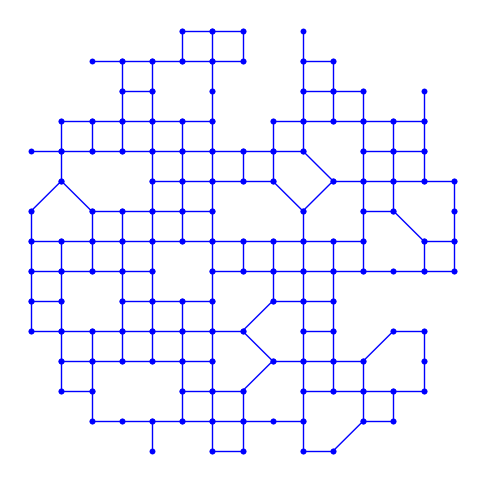

In [ ]:
# Personal Student ID: x23127635
random.seed(0)
#generateRandomGraph(nodes,size of the map )
V, E = generateRandomGraph(150, 5000, 5000, 4500)
plotGraph(V, E)

In [ ]:
#The random generation may result in a graph consisting of multiple not connected subgraphs.
#Split a graph into not connected subgraphs, if any.

def subgraph(P, E):
    P = P.copy()
    E = E.copy()
    PP = [ P[0] ]
    EE = []
    P = P[1:]
    extended = True
    while extended:
        extended = False
        for (a, b) in E:
            if a in PP and b in P:
                PP.append(b)
                P.remove(b)
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
            if a in P and b in PP:
                PP.append(a)
                P.remove(a)
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
            if a in PP and b in PP:
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
    return PP, EE, P, E

In [ ]:
def generateGraph(n, x0, y0, r):
    P, E = generateRandomGraph(n, x0, y0, r)
    P0, _, P1, _ = subgraph(P, E)
    while len(P1)>0:
        (p, q) = nearest(P0, P1)
        E.append((p, q))
        P0, _, P1, _ = subgraph(P, E)
    return P, E

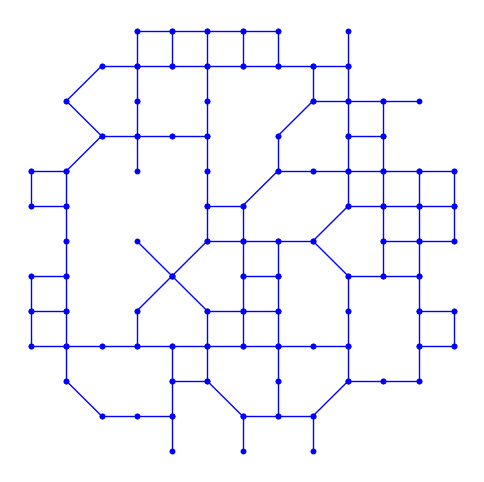

In [ ]:
random.seed(0)
V, E = generateGraph(100, 5000, 5000, 4500)
plotGraph(V, E)

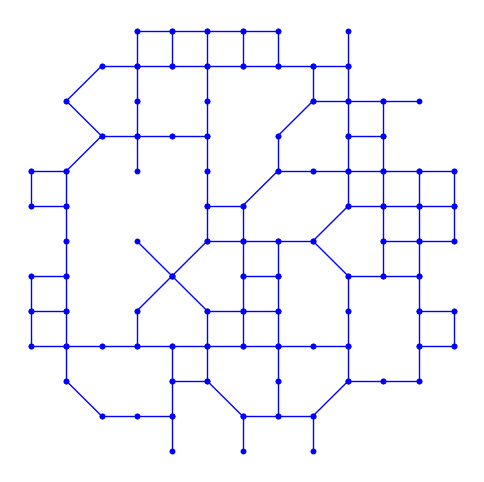

In [ ]:
random.seed(0)
V, E = generateGraph(100, 5000, 5000, 4500)
plotGraph(V, E)

Graph for seed 0 has 100 vertices and 136 edges


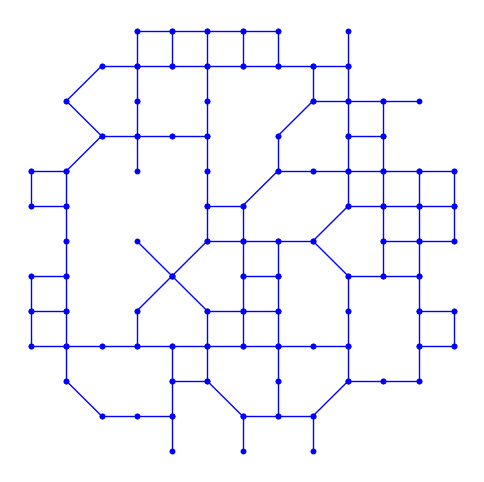

In [ ]:
i=0
random.seed(i)
P, E = generateGraph(100, 4000, 4000, 4000)
print("Graph for seed", i, "has", len(P), "vertices and", len(E), "edges")
plotGraph(P, E)
plt.show()

## Lists and Paths

In [ ]:
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [ ]:
def reverse(P):
    return [ P[-i] for i in range(1,len(P)+1) ]

In [ ]:
def index(x, L):
    for i in range(len(L)):
        if x==L[i]:
            return i
    return None

In [ ]:
def addWithoutDuplicates(L, X):
    for i in range(len(X)):
        if X[i] not in L:
            L.append(X[i])
    return L

## Generate Customer Locations

In [ ]:
def splitEdgeRandomly(V, E, s):
    A, B = s
    p = random.uniform(0.3,0.7)
    x = int(A[0]+p*(B[0]-A[0]))
    y = int(A[1]+p*(B[1]-A[1]))
    t = (x,y)
    E.remove(s)
    E.append((A, t))
    E.append((t, B))
    V.append(t)
    return (V, E), t

In [ ]:
def generateRandomTargets(V, E, n=5):
    V, E = V.copy(), E.copy()
    T = []
    # we want to ensure that the beginning of the
    # sequence of points generated randomly stays
    # the same
    mindist = 300
    while len(T)<n:
        s = random.choice(E)
        A, B = s
        if dist(A,B)>mindist: # avoid targets placed narrowly
            (V, E), t = splitEdgeRandomly(V, E, s)
            T.append(t)
    return sorted(T)

## Add Targets

In [ ]:
def addTargets(M, T):
    V, E = M
    E = E.copy()
    V = V.copy()
    for t in T:
        minD = math.inf
        minE = None
        for e in E:
            P, Q = e
            distT = dist(P, t)+dist(t, Q)-dist(P, Q)
            if distT < minD:
                minD = distT
                minE = e
        P, Q = minE
        E.remove( (P, Q) )
        E.append( (P, t) )
        E.append( (t, Q) )
        V.append(t)
    return V, E

## PlotMap with Delivery Route

In [ ]:
def plotMap(G, T=[], P=[], W=None,
            style='r-o', lw=1, ms=3,
            styleT='go', msT=5,
            styleP='b-o', lwP=3, msP=1,
            stylePT='go', msPT=7,
            styleW='bo', msW=9,
            text=None, grid=False):
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    V, E = G

    if not grid:
        plt.axis('off')
    plt.plot( [ p[0] for p in V ], [ p[1] for p in V ], 'ro', lw=lw, ms=ms)
    for (p, q) in E:
        plt.plot( [ p[0], q[0] ], [ p[1], q[1] ], 'r-o', lw=lw, ms=ms)
    for t in T:
        plt.plot( [ t[0] ], [ t[1] ],
                 styleT, ms=msT)
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ],
              styleP, lw=lwP, ms=msP)
    for p in P:
        if p in T:
            plt.plot( [ p[0] ], [ p[1] ],
                      stylePT, ms=msPT)
    if W is not None:
        plt.plot( [ W[0] ], [ W[1] ],
                      styleW, ms=msW)
    if text is not None:
        maxX = max([p[0] for p in V])
        plt.text(0.8*maxX, 0, text)
    if grid:
        plt.grid()
    plt.show()

## Generate Warehouse Location

This is a blind random generation as it would be needed for a Monte-Carlo Optimisation.
You may improve this algorithm to reduce the search space.

In [ ]:
def generateWarehouseLocation(M):
    V, _ = M
    W = random.sample(V, k=1)[0]
    return W

## Generate Data

In [ ]:
def generateData(seed=None, nodes=100, customers=150,
                 plot=False, log=False):

    if seed is None:

        print("Usage:  M, C = generateData(seed=None, ")
        print("                            nodes=100, customers=50, ")
        print("                            plot=False, log=False)")
        print("")
        print("  seed  the seed value to be used for data generation. ")
        print("        To test the application use seed=0, it will create")
        print("        a small map, with a very few customer locations and")
        print("        a small set of delivery data.")
        print("")
        print("  nodes the number of intersections (vertices) in the generated map")
        print("")
        print("  customers  the number of customers generated on the map")
        print("")
        print("  log   Controls print output during data generation.")
        print("")
        print("  plot  Controls graphical output during data generation.")
        print("")
        print("Returns:")
        print("")
        print("  M = (V, E) is the generated map given as a graph")
        print("    where V is a list of vertices, with each vertice ")
        print("    given as a pair (x, y) of integer coordinates, ")
        print("    and E is a list of edges, with each edge given")
        print("    as a pair (A, B) of vertices, with each vertex again")
        print("    given as a pair (x, y) of integer coordinates")
        print("")
        # print("  W ∈ V  is the location of the distribution warehouse")
        # print("    given as a pair (x, y) of integer coordinates")
        # print("")
        print("  C is a list of customer locations")
        print("    given as pairs (x, y) of integer coordinates on or near")
        print("    existing edges E. To integrate a set of customer locations")
        print("    into a given map M = (V, E), use addTarget(M, C)")
        print("")

        seed = 0

    if seed==0:          # generate very simple test data
        nodes = 20       # number of points in map
        customers = 5    # number of  customers
        grid = True

    else:
        grid = False

    random.seed(seed)

    V, E = generateGraph(nodes, 4000, 4000, 4000)

    C = generateRandomTargets(V, E, customers)

    if log:
        print(f"Generated map with {nodes:d} nodes and "
              f"{customers:d} customer locations")
    if plot:
        label="" if seed==0 else f"seed={seed:4d}"
        plotMap((V, E), T=C, text=label, grid=grid)

    return (V, E), C

In [ ]:
D1 = generateData(0)
D2 = generateData(0)
D1 == D2

True

### General Help Message

In [ ]:
# If you use generateData() without any parameters you will get a general help message

M, C = generateData()

Usage:  M, C = generateData(seed=None, 
                            nodes=100, customers=50, 
                            plot=False, log=False)

  seed  the seed value to be used for data generation. 
        To test the application use seed=0, it will create
        a small map, with a very few customer locations and
        a small set of delivery data.

  nodes the number of intersections (vertices) in the generated map

  customers  the number of customers generated on the map

  log   Controls print output during data generation.

  plot  Controls graphical output during data generation.

Returns:

  M = (V, E) is the generated map given as a graph
    where V is a list of vertices, with each vertice 
    given as a pair (x, y) of integer coordinates, 
    and E is a list of edges, with each edge given
    as a pair (A, B) of vertices, with each vertex again
    given as a pair (x, y) of integer coordinates

  C is a list of customer locations
    given as pairs (x, y) of integer

## Real Sample Data

Generated map with 100 nodes and 150 customer locations


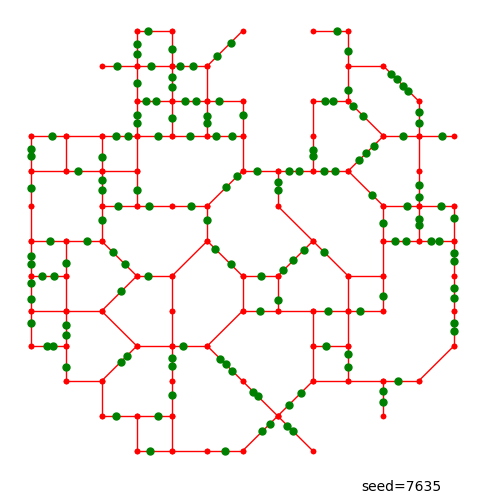

In [ ]:
# Sample data for the required simulation.
data =generateData(7635, plot=True, log=True)

In [ ]:
#Save data as pickle file
import pickle
with open('data.pickled', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
# Assigning elements from data (pickle file)
# M: Map of the townships
# C: Customers addresses
M, C = data

In [ ]:
#Identify the points in the grid above: vertices and edges
V, E = M

In [ ]:
#The Warehouse address
random.seed(0)
W= generateWarehouseLocation(M)
W

(3440, 6800)

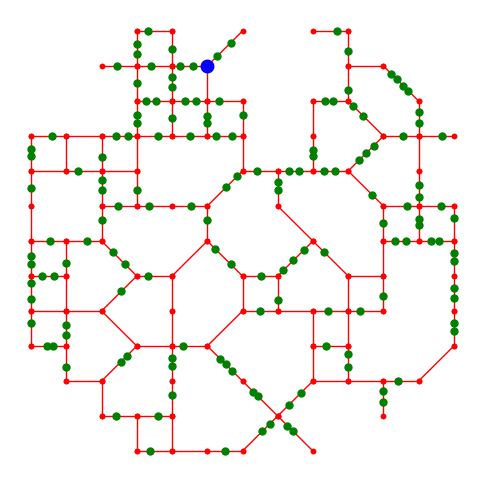

In [ ]:
plotMap((V, E), T=C, W=W)

## Loading Sample Data

In [ ]:
import pickle
with open('data.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [ ]:
#Split the map into Vertices and Edges:
V, E = M

In [ ]:
#Pick a random location for the Warehouse at one of the intersections (vertices) on the map
random.seed(7635)
W = generateWarehouseLocation(M)

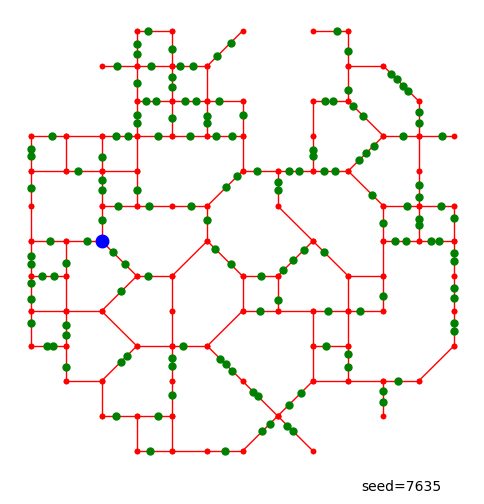

In [ ]:
plotMap(M, T=C, P=[], W=W, text="seed=7635")

In [ ]:
W

(1760, 4000)

## 2.11 Time Handling

**Convention:** In this project we measure time in seconds. The simulation will start at 0:00. Time related methods will be added as they are needed.

`timestamp(t)` generates a timestamp string in the form `[dd] hh:mm:ss.d`

In [ ]:
    def timestamp(t):
        day = int(t)//(24*3600)
        t = t - day*24*3600
        hour = int(t)//3600
        t = t - hour*3600
        mins = int(t)//60
        t = t - mins*60
        secs = int(math.floor(t))
        t = int(math.floor((t - secs)*10))
        return f"[{day:2d}] {hour:02d}:{mins:02d}:{secs:02d}.{t:1d}"

In [ ]:
timestamp(24*3600*3+17*3600+615.1)

'[ 3] 17:10:15.0'

In [ ]:
def nextHour(env, hour):
    beginningOfDay = int(env.now//(24*3600))*24*3600
    timeOfDay = env.now-beginningOfDay
    if hour*3600 > timeOfDay:
        return hour*3600 - timeOfDay
    else:
        return hour*3600 + 24*3600 - timeOfDay

In [ ]:
def day(now):
    return int(now//(24*3600))

## Plotting Routines

In [ ]:
import scipy.stats as stats

def histplot(data, title="", xlabel="",
             width=None, height=None):

    minx = min(data)
    maxx = max(data)
    μ = np.mean(data)
    σ = np.std(data)

    fig = plt.figure()
    fig.set_figwidth(width if width is not None else 4)
    fig.set_figheight(height if height is not None else 2.5)
    ax = fig.gca()

    hist=plt.hist(data, density=True)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.title(title)

    x = np.linspace(minx, maxx, 100)
    y = [ stats.norm(loc=μ, scale=σ).pdf(p) for p in x]
    ax.plot(x, y, lw=1, color='red')
    ax.axvline(x=μ, color='red')
    maxy = max(max(y), max(hist[0]))
    ax.text(maxx, maxy,
            f'μ={μ:2.2f}\nσ={σ:2.2f}',
            ha='right', va='top',
            color='red', fontsize=12)
    ax.grid(True)
    plt.show()

In [ ]:
def dailyPlot(data,
              title="", ylabel="",
              width=None, height=None):

    days = len(data)

    fig = plt.figure()
    fig.set_figwidth(width if width is not None else 6)
    fig.set_figheight(height if height is not None else 2)

    ax = fig.gca()
    diff = (max(data)-min(data))*0.1
    ymin = int(math.floor(min(data)-diff))
    ymax = int(math.ceil(max(data)+diff))
    ax.set_xlim(-1, days)
    ax.set_ylim(ymin, ymax)
    ax.grid(True)

    ms = 2 if len(data)>100 else 5
    lw = 0.5 if len(data)>100 else 1

    x = np.arange(0, len(data))
    y = np.array([ y for y in data ])
    b, m = np.polynomial.polynomial.polyfit(x, y, 1)

    plt.plot(x, y, 'bo-', linewidth=lw, markersize=ms)
    plt.plot(x, m*x+b, 'r-')

    plt.xlabel('Day')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# 3. Finding Shortest Path

## 3.1 The Algorithm

This is the $A^{*}$ algorithm introduced in Week 3.

In [ ]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.sqrt((x1-x2)**2+(y1-y2)**2))

In [ ]:
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [ ]:
def shortestPath(M, A, B):

    def h(p):
        return pathLength(p)+dist(p[-1],B)

    # candidates C are pairs of the path so far and
    # the heuristic function of that path,
    # sorted by the heuristic function, as maintained by
    # insert function
    def insert(C, p):
        hp = h(p)
        c = (p, hp)
        for i in range(len(C)):
            if C[i][1]>hp:
                return C[:i]+[c]+C[i:]
        return C+[c]

    V, E = M
    assert(A in V and B in V)
    C = insert([], [A])

    while len(C)>0:
        # take the first candidate out of the list of candidates
        path, _ = C[0]
        C = C[1:]
        if path[-1]==B:
            return path
        else:
            for (x, y) in E:
                if path[-1]==x and y not in path:
                    C = insert(C, path+[y])
                elif path[-1]==y and x not in path:
                    C = insert(C, path+[x])
    return None

## 3.2 Testing

In [ ]:
A = C[0]
B = C[-1]

In [ ]:
MAB = addTargets(M, [A, B])

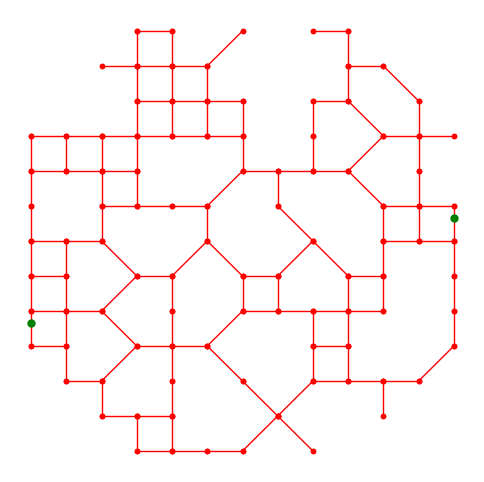

In [ ]:
plotMap(MAB, T=[A, B])

In [ ]:
P = shortestPath(MAB, A, B)

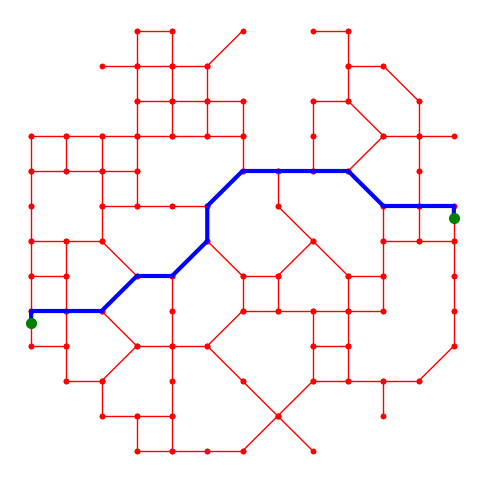

In [ ]:
plotMap(MAB, T=[A, B], P=P)

# 4. Finding Shortest Delivery Route

## Iterative Integer Programming

In [ ]:
def createTables(M, T):

    def reverse(P):
        return [ P[-i] for i in range(1,len(P)+1) ]

    def index(x, L):
        for i in range(len(L)):
            if x==L[i]:
                return i
        return None

    n = len(T)
    d = [ [ math.inf for t in T ] for t in T ]
    p = [ [ None for t in T ] for t in T ]
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [ T[i] ]
    for i in range(n):
        for j in range(n):
            if p[i][j] is None:
                s = shortestPath(M, T[i], T[j])
                d[i][j] = d[j][i] = pathLength(s)
                p[i][j] = s
                p[j][i] = reverse(s)
                for m in range(len(s)-1):
                    smi = index(s[m], T)
                    if smi is None:
                        continue
                    for l in range(m+1, len(s)):
                        sli = index(s[l], T)
                        if sli is None:
                            continue
                        sub = s[m:l+1]
                        if p[smi][sli] is None:
                            p[smi][sli] = sub
                            p[sli][smi] = reverse(sub)
                            d[smi][sli] = d[sli][smi] = pathLength(sub)
    return d,p

In [ ]:
def roundtrips(x, n):

    def isElem(x, l):
        for i in range(len(l)):
            if l[i]==x:
                return True
        return False

    def startpoint(trips):
        for i in range(n):
            for t in trips:
                if isElem(i, t):
                    break
            else:
                return i

    def totalLength(trips):
        s=0
        for i in range(0, len(trips)):
            s += len(trips[i])-1
        return s

    trips = []
    while totalLength(trips)<n:
        start = startpoint(trips)
        trip = [ start ]
        i = start
        while len(trip) < n-totalLength(trips):
            for j in range(0, n):
                if pulp.value(x[i][j])==1:
                    trip.append(j)
                    i=j
                    break
            if pulp.value(x[trip[-1]][start])==1:
                trip.append(start)
                break
        trips.append(trip)
    return sorted(trips, key=lambda t: len(t), reverse=True)

In [ ]:
import time

def createLoop(M, T, timing=False):

    if timing:
        start_time = time.time()
        last_time = time.time()

    D, P = createTables(M, T)   # These are the distances between customers and warehouse only

    if timing:
        print(f"createTables:   {time.time()-start_time:6.2f}s")
        last_time = time.time()

    n = len(T)

    if n==1:
        return T

    # create variables
    x = pulp.LpVariable.dicts("x", ( range(n), range(n) ),
                            lowBound=0, upBound=1, cat=pulp.LpInteger)
    # create problem
    prob = pulp.LpProblem("Loop",pulp.LpMinimize)
    # add objective function
    prob += pulp.lpSum([ D[i][j]*x[i][j]
                             for i in range(n) for j in range(n) ])
    # add constraints
    constraints=0
    for j in range(n):
        prob += pulp.lpSum([ x[i][j] for i in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        prob += pulp.lpSum([ x[i][j] for j in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        for j in range(n):
            if i!=j:
                prob += x[i][j]+x[j][i] <= 1
                constraints += 1
    # initialise solver
    solvers = pulp.listSolvers(onlyAvailable=True)
    solver = pulp.getSolver(solvers[0], msg=0)
    prob.solve(solver)

    if timing:
        print(f"Solver:         {time.time()-last_time:6.2f}s {constraints:6,d} Constraints")
        last_time = time.time()

    trips = roundtrips(x, n)
    while len(trips)>1:
        longest = max([ len(t) for t in trips ])
        for t in trips:
            if len(t)<longest:
                prob += pulp.lpSum([ x[t[i]][t[i+1]] + x[t[i+1]][t[i]]
                                        for i in range(0,len(t)-1) ]) <= len(t)-2
                constraints += 1
            else:
                longest = math.inf
        prob.solve(solver)

        if timing:
            print(f"Solver:         {time.time()-last_time:6.2f}s {constraints:6,d} Constraints")
            last_time = time.time()

        trips = roundtrips(x, n)

    trip = trips[0]
    loop = []
    for k in range(len(trip)-1):
        sub = P[trip[k]][trip[k+1]]
        loop += sub if len(loop)==0 else sub[1:]

    if timing:
        print(f"createLoop:     {time.time()-start_time:6.2f}s")

    return loop

## 4.2 Heuristic Algorithm

In [ ]:
def FW(M):

    V, E = M

    n = len(V)
    d = [ [ math.inf for j in range(n) ] for i in range(n) ]
    p = [ [ None for j in range(n) ] for i in range(n) ]

    for (A, B) in E:
        a = V.index(A)
        b = V.index(B)
        d[a][b] = d[b][a] = dist(A, B)
        p[a][b] = [A, B]
        p[b][a] = [B, A]

    for i in range(n):
        d[i][i] = 0
        p[i][i] = [V[i]]

    for k in range(n):
        for i in range(n):
            for j in range(n):
                dk = d[i][k] + d[k][j]
                if d[i][j] > dk:
                    d[i][j] = dk
                    p[i][j] = p[i][k][:-1] + p[k][j]

    return d, p

In [ ]:
def createLoopH(M, T, timing=False):

    def makeLoop(L):
        loop = []
        for i in range(len(L)-1):
            A = L[i]
            B = L[i+1]
            a = V.index(A)
            b = V.index(B)
            sub = P[a][b]
            loop += sub if len(loop)==0 else sub[1:]
        return loop

    if timing:
        start_time = time.time()
        last_time = time.time()

    V, E = M
    D, P = FW(M)   # note these are the distances between all vertices in M (and T)

    if timing:
        print(f"createTables:   {time.time()-start_time:6.2f}s")
        last_time = time.time()

    W = T[0]
    customers = T[1:]
    if len(T)==1:
        L = T
    elif len(T)<=3:
        L = T + [T[0]]
    else:
        L = T[:3]+[T[0]]
        T = T[3:]
        while len(T)>0:
            minExt = math.inf
            minInd = None
            selInd = None
            for k in range(len(T)):
                C = T[k]
                c = V.index(C)
                for i in range(0, len(L)-1):
                    A = L[i]
                    B = L[i+1]
                    a = V.index(A)
                    b = V.index(B)
                    ext = D[a][c] + D[c][b] - D[a][b]
                    if ext<minExt:
                        minExt, minInd, selInd = ext, i+1, k
            L = L[:minInd]+[T[selInd]]+L[minInd:]
            T = T[:selInd]+T[selInd+1:]

    if timing:
        print(f"createLoopH:    {time.time()-start_time:6.2f}s")

    return makeLoop(L)

## 4.3 Greedy Algorithm

In [ ]:
def createLoopG(M, T, plot=False, timing=False):

    def makeLoop(L):
        loop = []
        for i in range(len(L)-1):
            A = L[i]
            B = L[i+1]
            a = V.index(A)
            b = V.index(B)
            sub = P[a][b]
            loop += sub if len(loop)==0 else sub[1:]
        return loop

    if timing:
        start_time = time.time()

    V, E = M
    D, P = FW(M)   # note these are the distances between all vertices in M (and T)

    if timing:
        print(f"Floyd-Warshall: {time.time()-start_time:6.2f}s")

    W = T[0]
    customers = T[1:]
    if len(T)==1:
        L = T
    elif len(T)<=3:
        L = T + [T[0]]
    else:
        L = T[:3]+[T[0]]
        T = T[3:]
        while len(T)>0:
            if plot:
                loop = makeLoop(L)
                plotMap(M, T=L, P=loop, w=W,
                        grid=True, text=f"{pathLength(loop):,d}m")
            minExt = math.inf
            minInd = None
            selInd = None
            for k in range(len(T)):
                C = T[k]
                c = V.index(C)
                for i in range(0, len(L)-1):
                    A = L[i]
                    B = L[i+1]
                    a = V.index(A)
                    b = V.index(B)
                    ext = D[a][c] + D[c][b] - D[a][b]
                    if ext<minExt:
                        minExt, minInd, selInd = ext, i+1, k
            L = L[:minInd]+[T[selInd]]+L[minInd:]
            T = T[:selInd]+T[selInd+1:]

    if timing:
        print(f"createLoopG:    {time.time()-start_time:6.2f}s")

    return makeLoop(L)

### Delivering to 30 Customers

In [ ]:
random.seed(0)
T = random.sample(C, k=len(C)//5)

In [ ]:
len(T)

30

In [ ]:
MC = addTargets(M, T)

In [ ]:
# Iterative Integer Programming
PC = createLoop(MC, [W] + T, timing=True)

createTables:     0.30s
Solver:           0.39s    992 Constraints
Solver:           0.24s    993 Constraints
Solver:           0.23s    995 Constraints
Solver:           0.24s    996 Constraints
Solver:           0.28s    997 Constraints
Solver:           0.21s    998 Constraints
Solver:           0.21s    999 Constraints
Solver:           0.22s  1,000 Constraints
Solver:           0.26s  1,001 Constraints
Solver:           0.28s  1,002 Constraints
Solver:           0.40s  1,003 Constraints
createLoop:       3.25s


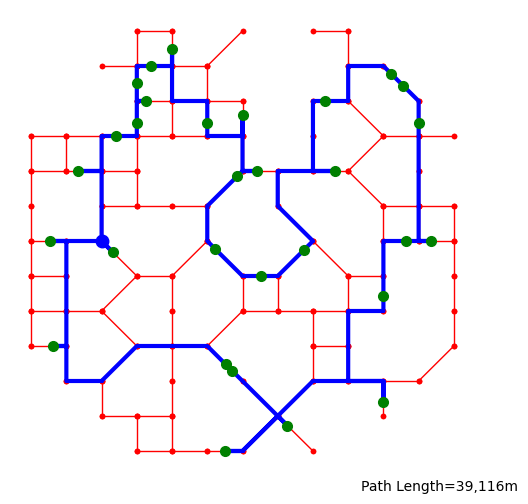

In [ ]:
plotMap(MC, T=T, W=W, P=PC, text=f"Path Length={pathLength(PC):3,d}m")

In [ ]:
# Greedy Algorithm
PG = createLoopG(MC, [W]+T, timing= True)

Floyd-Warshall:   0.20s
createLoopG:      0.21s


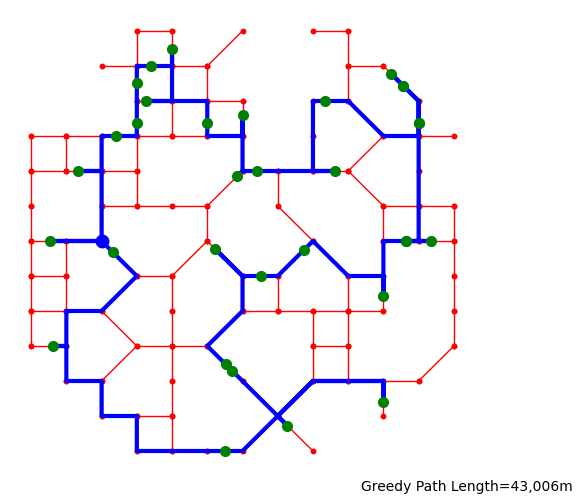

In [ ]:
plotMap(MC, T=T, W=W, P=PG, text=f"Greedy Path Length={pathLength(PG):3,d}m")

In [ ]:
# Heuristic Algorithm
PH = createLoopH(MC, [W]+T, timing=True)

createTables:     0.18s
createLoopH:      0.19s


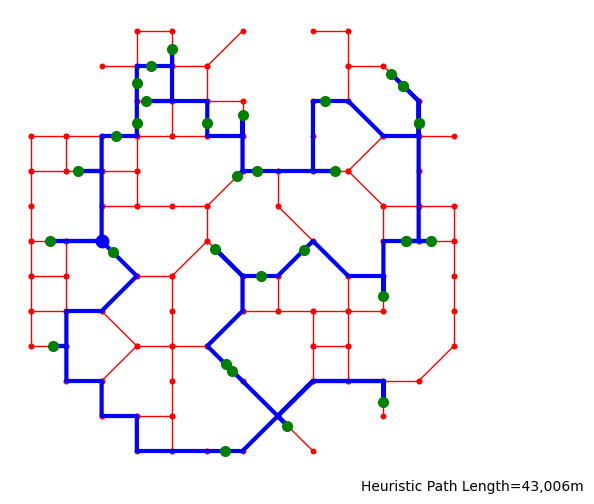

In [ ]:
plotMap(MC, T=T, W=W, P=PH, text=f"Heuristic Path Length={pathLength(PH):3,d}m")

In [ ]:
PH.reverse()

In [ ]:
P == PH

False

# Class Recorder

We willl use a class Recorder as a reference point for capturing data during the simulation. There will be only one recorder. It will be created at the beginning of every simulation run. Every entity will carry a reference to the Recorder.

In [ ]:
class Recorder:

    def __init__(self, env, M, W, C, days,
                 log=False, plot=False, timing=False):
        self.env = env
        self.M = M
        self.W = W
        self.C = C
        self.days = days
        self.log = log
        self.plot = plot

        self.timing = timing
        self.start_time = time.time()
        self.last_time = self.start_time
        self.cum_timer = {}

        Customer.REGISTER = []
        Parcel.REGISTER = []

        # create a data frame for records per working day
        self.daily = pd.DataFrame()
        self.daily['begin work at'] = [None]*days
        self.daily['end work at'] = [None]*days
        self.daily['dist'] = [None]*days
        self.daily['left'] = [None]*days
        self.daily['cost']=[None]*days #adding daily costs

    def timer(self, s):
        t = time.time()
        Δt = t-self.last_time
        if self.timing:
            print(f"==== t: {t-self.start_time:6.2f}s "
                  f"Δt: {Δt:6.2f}s [{s:s}]")
        if s in self.cum_timer:
            self.cum_timer[s] += Δt
        else:
            self.cum_timer[s] = Δt
        self.last_time = t

    def reportTimer(self):
        print(f"==== t: {self.total_time:6.2f}s Total")
        for k in sorted(self.cum_timer, key=lambda x: self.cum_timer[x], reverse=True):
            print(f"==== ΣΔt: {self.cum_timer[k]:6.2f}s "+ k)

    def trace(self, event):
        if self.log:
            print(timestamp(self.env.now), event)

    def recordDriverBeginsWork(self):
        self.trace("Driver arrives for work")
        self.daily.at[day(self.env.now), 'begin work at'] = int(round(self.env.now))

    def recordDriverEndsWork(self):
        self.trace("Driver goes home")
        self.daily.at[day(self.env.now), 'end work at'] = int(round(self.env.now))

    def recordTourLength(self, length):
        self.daily.at[day(self.env.now), 'dist'] = int(length)

    def recordParcelsLeftOver(self, numberOfParcels):
        self.trace(f"{numberOfParcels:d} left over for next day")
        self.daily.at[day(self.env.now), 'left'] = numberOfParcels

    def recordCost(self, HOURLY_RATE=30, MINIMUM_WORKING_DAY=60):
#        self.daily.at[day(self.env.now), 'cost'] = int(length)
        for i, row in self.daily.iterrows():
            working_time = (row['end work at']-row['begin work at'])//60
            tour_length = row['dist']
            electric_cargo_bike= (row['dist']//1000) * OPERATIONAL_COST
            hourly_cost = max(MINIMUM_WORKING_DAY, (working_time//60) * HOURLY_RATE)
            #self.daily.at[i, 'cost'] = (tour_length/hourly_cost)+ electric_cargo_bike
            self.daily.at[i,'cost'] = (tour_length//hourly_cost) + electric_cargo_bike

    def finish(self):
        # simulation is finished for good
        # by removing the simulation environment we can
        # pickle recorder
        self.recordCost()
        self.env = None
        self.total_time = time.time()-self.start_time
        self.daily['working time'] = (self.daily['end work at']-self.daily['begin work at'])//60


    def __stats__(self, column):
        d = self.daily[column].copy()
        return d.mean(), d.median(), d.std()

    def statsWorkingTime(self):
        return self.__stats__('working time')

    def histWorkingTime(self):
        histplot(self.daily['working time'],
                 xlabel='Working Time [min]',
                 title='Daily Working Time')

    def plotWorkingTime(self):
        dailyPlot(self.daily['working time'],
                  ylabel='Working Time [min]',
                  title='Daily Working Time')

    def statsTourLength(self):
        return self.__stats__('dist')

    def histTourLength(self):
        histplot(self.daily['dist'],
                 xlabel='Tour Length [m]',
                 title='Daily Tour Length')

    def plotTourLength(self):
        dailyPlot(self.daily['dist'],
                  ylabel='Tour Length [m]',
                  title='Daily Tour Length')

    def statsLeftOver(self):
        return self.__stats__('left')

    def histLeftOver(self):
        histplot(self.daily['left'],
                 xlabel='Left-Over Parcels',
                 title='Daily Left-Over Parcels')

    def plotLeftOver(self):
        dailyPlot(self.daily['left'],
                  ylabel='Number of Parcels',
                  title='Daily Left-Over Parcels')

    def statsCosts(self):
        return self.__stats__('cost')

    def histCosts(self):
        histplot(self.daily['cost'],
                 xlabel='Costs [€]',
                 title='Daily Costs')

    def plotCosts(self):
        dailyPlot(self.daily['cost'],
                  ylabel='Tour Cost [€]',
                  title='Daily Cost')


# Class Parcel

<img src='img/EventGraph Parcel.png' width=500/>

Parcels follow through a sequence of states:
- processing
- in transit (from manufacture to distribution centre)
- arrived in distribution centre
- ready for delivery
- out for delivery
- customer not present
- returned to distribution centre
- delivered

In [ ]:
class Parcel:

    REGISTER = []

    def __init__(self, rec, i, cust, custIndex):
        self.rec = rec
        self.i = i  # row index in data frames of input data
        self.dest = cust.location
        self.custIndex = custIndex
        self.status = [ 'processing' ] # status record and
        self.timing = [ self.rec.env.now ]      # timing
        assert(len(Parcel.REGISTER)==i)
        Parcel.REGISTER += [ self ]

    # factory method ensures that there is only
    # one Parcel per location
    def getParcel(rec, i, location, custIndex):
        for p in Parcel.REGISTER:
            if p.i == i:
                return p
        return Parcel(rec, i, location, custIndex)


    def __str__(self):
        return f"Parcel: {self.i:3d} ({self.custIndex:3d})"

    def index(self):
        return self.i

    def destination(self):
        return self.dest

    def __reg(self, state):
        self.status += [ state ]
        self.timing += [ self.rec.env.now ]
        self.rec.trace(str(self)+" "+state)

    def arrivedAtDeliveryCentre(self):
        self.__reg('arr at delivery centre')

    def outForDelivery(self):
        self.__reg('out for delivery')

    def returnFromDelivery(self):
        self.__reg('return from delivery')


# Class Customer

<img src='img/EventGraph Customer.png' width=500/>

In [ ]:
class Customer:

    REGISTER = []

    def __init__(self, rec, location):
        self.rec = rec
        self.location = location
        self.i = len(Customer.REGISTER)
        Customer.REGISTER += [ self ]
        self.atHome = True
        self.answersDoor = False
        self.parcelsReceived = []
        rec.env.process(self.process())

    def __str__(self):
        return f"Customer: {self.i:2d} {str(self.location):s}"

    # factory method ensures that there is only
    # one customer per location
    def getCustomer(rec, location):
        for c in Customer.REGISTER:
            if c.location == location:
                return c
        return Customer(rec, location)

    def leaveHouse(self):
        assert(self.atHome and not self.answersDoor)
        # self.rec.trace(str(self)+" leaves house")
        self.atHome = False

    def returnHome(self):
        assert(not self.atHome)
        # self.rec.trace(str(self)+" returns home")
        self.atHome = True

    def answerDoor(self):
        if self.atHome:
            yield self.rec.env.timeout(random.expovariate(1/AVERAGE_TIME_ANSWER_DOOR))
            self.rec.trace(str(self)+" answers door")
            self.answersDoor = True
        else:
            yield self.rec.env.timeout(WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR)
            self.rec(str(self)+" not at home")

    def acceptParcel(self, parcel):
        assert(self.answersDoor)
        self.parcelsReceived += [parcel]
        self.rec.trace(str(self)+" accepts "+str(parcel))

    def signOff(self):
        assert(self.answersDoor)
        self.rec.trace(str(self)+" signs off")
        self.answersDoor = False

    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 8))
        while day(self.rec.env.now)<self.rec.days:
            # in a refinement we may use random times
            self.leaveHouse()
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))
            self.returnHome()
            yield self.rec.env.timeout(nextHour(self.rec.env, 8))

# Class Driver

<img src='img/EventGraph Driver.png' width=500/>

In [ ]:
class Driver:

    def __init__(self, rec, DC):
        self.rec = rec
        self.DC = DC
        self.location = None
        self.parcels = None
        self.tour = None
        self.rec.env.process(self.process())

    # activity
    def __drive(self, target):
        assert(self.tour[0] == self.location)
        while self.location!=target:
            d = dist(self.location, self.tour[1])
            yield self.rec.env.timeout(d / AVERAGE_SPEED)
            self.location = self.tour[1]
            self.tour = self.tour[1:]
        assert(self.tour[0] == self.location == target)

    def arriveForWork(self):
        self.location = self.DC.W
        self.parcels = []
        self.returns = []
        self.tour = [ self.DC.W ]
        self.rec.recordDriverBeginsWork()

    def leaveForDelivery(self, tour, parcels):
        self.tour, self.parcels = tour, parcels
        self.rec.trace(f"Driver leaves for delivery " \
                       f"of {len(parcels):d} parcels")

    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 18))
        while day(self.rec.env.now)<self.rec.days:
            self.arriveForWork()
            tour, parcels = self.DC.sendForDelivery()
            yield self.rec.env.timeout(PREP_TIME_PER_PARCEL*len(parcels))
            self.rec.recordTourLength(pathLength(tour))
            self.leaveForDelivery(tour, parcels)
            while len(self.parcels)>0:
                # drive to customer
                custLocation = self.parcels[0].dest
                cust = Customer.getCustomer(self.rec, custLocation)
                self.rec.trace("Driver drives to "+str(cust))
                yield from self.__drive(custLocation)
                self.rec.trace("Driver arrived at "+str(cust))
                # call at customer
                yield from cust.answerDoor()

                if cust.answersDoor:
                    while len(self.parcels)>0 and \
                            custLocation == self.parcels[0].dest:
                        cust.acceptParcel(self.parcels[0])
                        yield self.rec.env.timeout(random.expovariate(1/10))
                        self.parcels = self.parcels[1:]
                    cust.signOff()
                    yield self.rec.env.timeout(random.expovariate(1/10))
                else:
                    while len(self.parcels)>0 and  \
                            custLocation == self.parcels[0].dest:
                        self.returns += self.parcels[0]
                        self.parcels = self.parcels[1:]

            # return to delivery centre
            self.rec.trace("Driver returns to delivery centre")
            yield from self.__drive(self.DC.W)
            self.rec.trace("Driver arrived at delivery centre")

            for parcel in self.returns:
                self.DC.returnFromDelivery(parcel)
                yield self.rec.env.timeout(RETURN_TIME_PER_PARCEL)
            yield self.rec.env.timeout(600)

            self.rec.recordParcelsLeftOver(len(self.DC.parcels)+
                                           len(self.DC.leftOver))

            self.rec.recordDriverEndsWork()

            yield self.rec.env.timeout(nextHour(self.rec.env, 18))

# Class Delivery Centre

<img src="img/EventGraph Delivery Centre.png" width=500/>

In [ ]:
class DeliveryCentre:

    def __init__(self, rec, M, W):
        self.rec = rec
        self.M = M
        self.W = W
        self.limit = 35000

        self.leftOver = []    # list of parcels
        self.parcels = []     # list of parcels scheduled for delivery
        self.dest = []        # list of unique customer destinations
        self.tour = None      # tour planned for delivery

    def __accept(self, parcel):
        custLoc = parcel.dest
        if custLoc not in self.dest:
            MT = addTargets(self.M, self.dest + [custLoc])
            self.rec.timer("addTarget")
            SH = createLoopH(MT, [self.W] + self.dest + [custLoc],
                             timing=self.rec.timing)
            self.rec.timer("createLoopH")
            if self.tour is None and pathLength(SH)<self.limit:
                self.parcels.append(parcel)
                self.dest += [custLoc]
            else:
                S = createLoop(MT, [self.W] + self.dest + [custLoc],
                               timing=self.rec.timing)
                self.rec.timer("createLoop")
                if pathLength(S)<self.limit:
                    self.parcels.append(parcel)
                    self.dest += [custLoc]
                    self.tour = S
                else:
                    self.leftOver.append(parcel)
        else:
            self.parcels.append(parcel)

    def acceptParcel(self, parcel):
        parcel.arrivedAtDeliveryCentre()
        self.__accept(parcel)

    def sendForDelivery(self):
        parcels = []
        if self.tour is None:
            MT = addTargets(self.M, self.dest)
            self.rec.timer("addTarget")
            self.tour = createLoop(MT, [self.W] + self.dest,
                                   timing=self.rec.timing)
            self.rec.timer("createLoop")
        tour = self.tour
        addresses = self.dest

        # pick parcels in sequence to be delivered
        for i in range(1, len(tour)-1):
            dest = tour[i]
            for p in self.parcels:
                if p.dest == dest and p not in parcels:
                    parcels += [p]
                    p.outForDelivery()

        # arrange the left overs
        L = self.leftOver
        self.tour = None
        self.parcels = []
        self.leftOver = []
        self.dest = []
        for p in L:
            self.__accept(p)

        if self.rec.plot:
            plotMap(self.rec.M, T=addresses, P=tour, W=tour[0],
                    text=f"Day {day(self.rec.env.now):2d}, {pathLength(tour):,d}m")

        return tour, parcels

    def returnFromDelivery(self, parcel):
        parcel.returnFromDelivery()
        self.__accept(parcel)

    def getInventory(self):
        return len(self.parcels)+len(self.leftOver)

# Simulation

## Parameters from Specification

The time required for driving is based on the distance between way points at an average speed of 15km/h.

In [ ]:
AVERAGE_SPEED = 15/3.6

The **cumulative preparation time** (route planning and
sorting of the parcels in the delivery order and
packing the cargo-bike) is assumed to be 50 sec per
parcel to be delivered.

In [ ]:
PREP_TIME_PER_PARCEL = 50

**Additional assumption:** The time to **process returned parcels** in the delivery centre is 30 sec per parce.

In [ ]:
RETURN_TIME_PER_PARCEL = 30

The average time to answer the door.

In [ ]:
AVERAGE_TIME_ANSWER_DOOR = 40

In [ ]:
WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR = 60

Payment of a driver per hour with a minimum of 60€ per working day

In [ ]:
HOURLY_RATE=30

In [ ]:
MINIMUM_WORKING_DAY= 60

The operational Cost (electricity and maintenance) of the electric cargo bike is 8 c/Km

In [ ]:
OPERATIONAL_COST= 0.08

## Generate Input Data

In [ ]:
def generateDeliveryData(p, C, days, seed=0):
    ## p is the average number of parcels per day per customer
    ## C is the number of customers to be served
    ## days is the number of days for which data are to be generated.
    np.random.seed(seed)
    R = np.random.poisson(lam=len(C)*p, size=days)
    D = [ sorted(list(np.random.choice(range(len(C)), size=i))) for i in R ]
    return D

In [ ]:
def generateInputData(D, log=False):

    R = [ len(d) for d in D ]
    N = sum(R)

    DAY_LENGTH = 24*3600    # measured in minutes
    DAY_START = 8*3600      # first delivery in the morning
    DAY_END = 17*3600     # last delivery during day time

    x = pd.DataFrame()

    x['iarr'] = [None]*N
    x['time'] = [None]*N
    x['day'] = [None]*N
    x['dest'] = [None]*N

    current_day = 0
    last_time = 0
    i = 0

    for d in D: # for each day

        if log:
            print("generating for day: ",current_day, D[current_day])

        time = current_day*DAY_LENGTH + DAY_START

        for c in d: # for each customer that should get a

            IARR = (DAY_END-DAY_START-2*3600) / len(d)  # estimated average IAT for the current day

            iat = random.expovariate(1.0/IARR)
            new_time = time + iat

            x.at[i, 'iarr'] = round(new_time - last_time,1)
            x.at[i, 'time'] = round(new_time - current_day*DAY_LENGTH , 1)
            x.at[i, 'day'] = current_day
            x.at[i, 'dest'] = c

            i += 1
            last_time = time = new_time

        current_day += 1

    return x

## Simulation Routine

In [ ]:
def simulation(M, W, C, p=0.2, days=10, title=None,
               seed=0, log=False, plot=False, timing=False):

    if timing:
        start_time = time.time()

    random.seed(seed)
    D = generateDeliveryData(p, C, days, seed)
    X = generateInputData(D, log=log)

    env = simpy.Environment()
    rec = Recorder(env, M, W, C, days, log=log, plot=plot, timing=timing)

    if title is not None:
        print(title)
    else:
        print(f"Simulating delivery of {len(X):d} parcels "
              f"over {len(D):d} days to {len(C):d} customers")

    for c in C:
        Customer.getCustomer(rec, c)
    DC = DeliveryCentre(rec, M, W)
    D = Driver(rec, DC)

    def generatorProcess(env):
        # generate the parcels based on input data x
        for i in range(len(X)):
            yield env.timeout(X.at[i, 'iarr'])
            custIndex = X.at[i, 'dest']
            custLoc = C[custIndex]
            cust = Customer.getCustomer(rec, custLoc)
            p = Parcel.getParcel(rec, i, cust, custIndex)
            DC.acceptParcel(p)

    env.process(generatorProcess(env))
    env.run()

    if log:
        print(f"Delivery Centre Inventory: {DC.getInventory():d} parcels")
    rec.finish()
    return rec

## Simulation

In [ ]:
import pickle
with open('data.pickled', 'rb') as f:
    M, C = pickle.load(f)

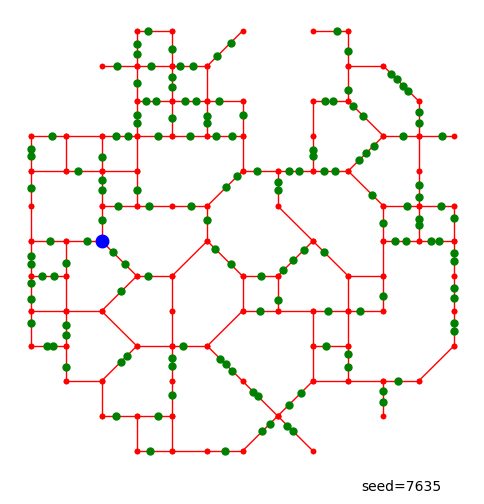

In [ ]:
plotMap(M, T=C, P=[], W=W, text="seed=7635")

In [ ]:
W

(1760, 4000)

generating for day:  0 [3, 11, 13, 18, 24, 31, 35, 40, 41, 43, 44, 67, 70, 71, 79, 83, 93, 104, 111, 118, 121, 125, 129]
generating for day:  1 [2, 3, 9, 11, 27, 29, 31, 32, 35, 39, 41, 46, 51, 53, 67, 73, 104, 108, 111, 125, 131, 137, 138, 148]
generating for day:  2 [0, 27, 33, 34, 34, 35, 36, 44, 61, 80, 85, 88, 91, 97, 112, 120, 126, 129, 133, 136, 138]
generating for day:  3 [2, 17, 25, 29, 30, 33, 35, 36, 44, 66, 67, 69, 84, 91, 101, 103, 111, 114, 116, 117, 140, 146]
generating for day:  4 [13, 16, 18, 24, 28, 39, 41, 43, 51, 58, 63, 72, 73, 81, 83, 85, 87, 87, 89, 91, 92, 93, 93, 94, 105, 106, 116, 116, 120, 123, 128, 136, 145, 147, 149]
generating for day:  5 [0, 4, 5, 14, 18, 20, 22, 25, 26, 28, 32, 34, 51, 52, 61, 64, 68, 74, 83, 92, 105, 117, 122, 135, 136, 139, 141]
generating for day:  6 [13, 13, 18, 22, 38, 44, 48, 51, 53, 55, 58, 58, 59, 70, 70, 80, 87, 94, 106, 121, 124, 135, 136]
generating for day:  7 [4, 6, 8, 24, 30, 49, 54, 56, 60, 79, 87, 100, 114, 144]
generatin

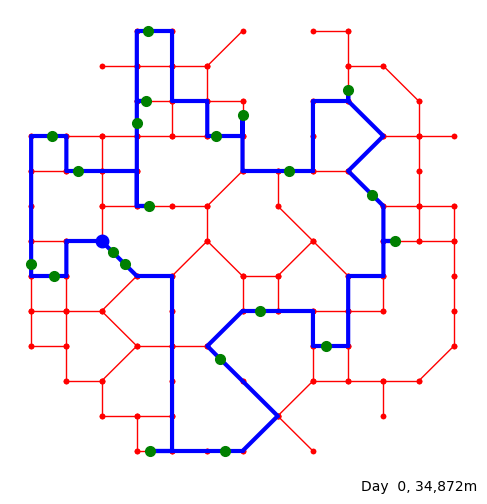

[ 0] 18:17:30.0 Driver leaves for delivery of 21 parcels
[ 0] 18:17:30.0 Driver drives to Customer: 13 (1008, 3440)
[ 0] 18:22:44.8 Driver arrived at Customer: 13 (1008, 3440)
[ 0] 18:22:46.4 Customer: 13 (1008, 3440) answers door
[ 0] 18:22:46.4 Customer: 13 (1008, 3440) accepts Parcel:   2 ( 13)
[ 0] 18:22:55.2 Customer: 13 (1008, 3440) signs off
[ 0] 18:23:05.5 Driver drives to Customer:  3 (640, 3632)
[ 0] 18:25:19.9 Driver arrived at Customer:  3 (640, 3632)
[ 0] 18:25:21.2 Customer:  3 (640, 3632) answers door
[ 0] 18:25:21.2 Customer:  3 (640, 3632) accepts Parcel:   0 (  3)
[ 0] 18:25:35.4 Customer:  3 (640, 3632) signs off
[ 0] 18:25:52.4 Driver drives to Customer: 11 (965, 5680)
[ 0] 18:35:22.0 Driver arrived at Customer: 11 (965, 5680)
[ 0] 18:35:24.9 Customer: 11 (965, 5680) answers door
[ 0] 18:35:24.9 Customer: 11 (965, 5680) accepts Parcel:   1 ( 11)
[ 0] 18:35:35.4 Customer: 11 (965, 5680) signs off
[ 0] 18:35:41.5 Driver drives to Customer: 18 (1390, 5120)
[ 0] 18:39:3

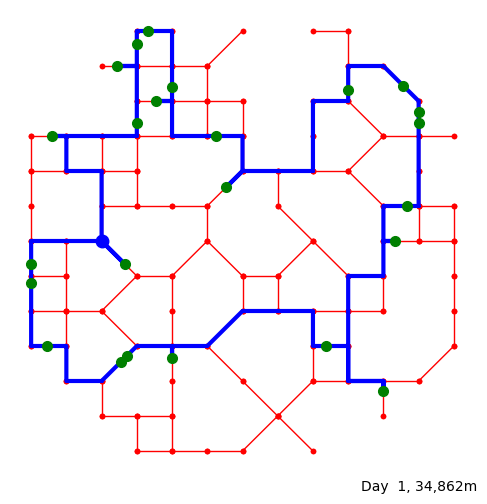

[ 1] 18:20:00.0 Driver leaves for delivery of 24 parcels
[ 1] 18:20:00.0 Driver drives to Customer: 11 (965, 5680)
[ 1] 18:29:53.9 Driver arrived at Customer: 11 (965, 5680)
[ 1] 18:29:54.5 Customer: 11 (965, 5680) answers door
[ 1] 18:29:54.5 Customer: 11 (965, 5680) accepts Parcel:  26 ( 11)
[ 1] 18:30:00.6 Customer: 11 (965, 5680) signs off
[ 1] 18:30:08.7 Driver drives to Customer: 35 (2320, 5885)
[ 1] 18:36:23.1 Driver arrived at Customer: 35 (2320, 5885)
[ 1] 18:37:45.2 Customer: 35 (2320, 5885) answers door
[ 1] 18:37:45.2 Customer: 35 (2320, 5885) accepts Parcel:  31 ( 35)
[ 1] 18:37:52.0 Customer: 35 (2320, 5885) signs off
[ 1] 18:37:52.9 Driver drives to Customer: 27 (2004, 6800)
[ 1] 18:42:48.3 Driver arrived at Customer: 27 (2004, 6800)
[ 1] 18:42:50.5 Customer: 27 (2004, 6800) answers door
[ 1] 18:42:50.5 Customer: 27 (2004, 6800) accepts Parcel:  27 ( 27)
[ 1] 18:43:10.3 Customer: 27 (2004, 6800) signs off
[ 1] 18:43:25.9 Driver drives to Customer: 39 (2320, 7159)
[ 1] 18

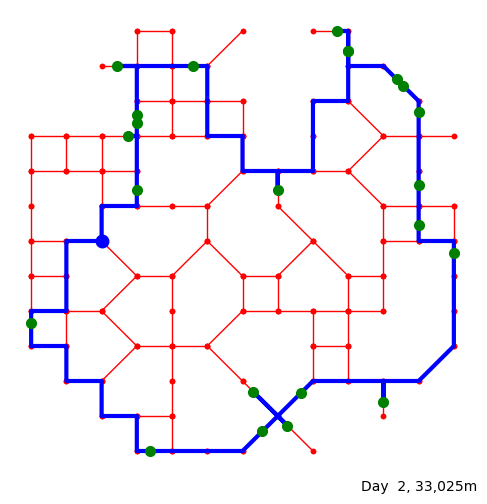

[ 2] 18:19:10.0 Driver leaves for delivery of 23 parcels
[ 2] 18:19:10.0 Driver drives to Customer:  0 (640, 2695)
[ 2] 18:28:51.9 Driver arrived at Customer:  0 (640, 2695)
[ 2] 18:29:12.9 Customer:  0 (640, 2695) answers door
[ 2] 18:29:12.9 Customer:  0 (640, 2695) accepts Parcel:  47 (  0)
[ 2] 18:29:23.7 Customer:  0 (640, 2695) signs off
[ 2] 18:29:57.5 Driver drives to Customer: 44 (2528, 640)
[ 2] 18:45:43.8 Driver arrived at Customer: 44 (2528, 640)
[ 2] 18:46:06.4 Customer: 44 (2528, 640) answers door
[ 2] 18:46:06.4 Customer: 44 (2528, 640) accepts Parcel:  54 ( 44)
[ 2] 18:46:12.1 Customer: 44 (2528, 640) signs off
[ 2] 18:46:18.5 Driver drives to Customer: 85 (4317, 957)
[ 2] 18:53:59.3 Driver arrived at Customer: 85 (4317, 957)
[ 2] 18:54:09.5 Customer: 85 (4317, 957) answers door
[ 2] 18:54:09.5 Customer: 85 (4317, 957) accepts Parcel:  57 ( 85)
[ 2] 18:54:14.5 Customer: 85 (4317, 957) signs off
[ 2] 18:54:24.9 Driver drives to Customer: 80 (4169, 1589)
[ 2] 18:57:59.4 D

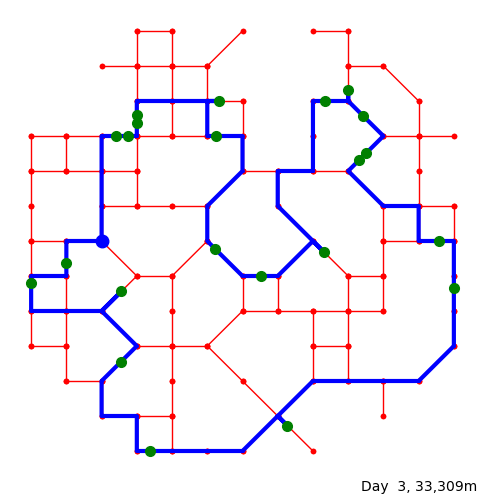

[ 3] 18:18:20.0 Driver leaves for delivery of 22 parcels
[ 3] 18:18:20.0 Driver drives to Customer: 25 (1990, 5680)
[ 3] 18:25:58.4 Driver arrived at Customer: 25 (1990, 5680)
[ 3] 18:26:58.5 Customer: 25 (1990, 5680) answers door
[ 3] 18:26:58.5 Customer: 25 (1990, 5680) accepts Parcel:  70 ( 25)
[ 3] 18:27:06.4 Customer: 25 (1990, 5680) signs off
[ 3] 18:27:14.5 Driver drives to Customer: 33 (2180, 5680)
[ 3] 18:28:00.1 Driver arrived at Customer: 33 (2180, 5680)
[ 3] 18:28:07.5 Customer: 33 (2180, 5680) answers door
[ 3] 18:28:07.5 Customer: 33 (2180, 5680) accepts Parcel:  73 ( 33)
[ 3] 18:28:09.8 Customer: 33 (2180, 5680) signs off
[ 3] 18:28:12.4 Driver drives to Customer: 35 (2320, 5885)
[ 3] 18:29:35.2 Driver arrived at Customer: 35 (2320, 5885)
[ 3] 18:30:05.0 Customer: 35 (2320, 5885) answers door
[ 3] 18:30:05.0 Customer: 35 (2320, 5885) accepts Parcel:  74 ( 35)
[ 3] 18:30:22.1 Customer: 35 (2320, 5885) signs off
[ 3] 18:30:26.5 Driver drives to Customer: 36 (2320, 6014)
[ 

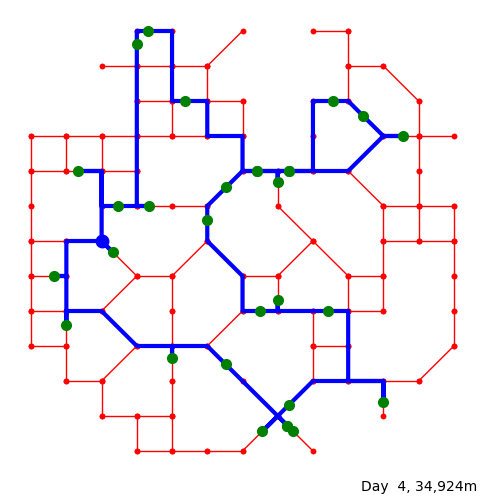

[ 4] 18:25:00.0 Driver leaves for delivery of 30 parcels
[ 4] 18:25:00.0 Driver drives to Customer: 13 (1008, 3440)
[ 4] 18:30:14.8 Driver arrived at Customer: 13 (1008, 3440)
[ 4] 18:31:32.5 Customer: 13 (1008, 3440) answers door
[ 4] 18:31:32.5 Customer: 13 (1008, 3440) accepts Parcel:  90 ( 13)
[ 4] 18:31:57.8 Customer: 13 (1008, 3440) signs off
[ 4] 18:31:59.6 Driver drives to Customer: 16 (1200, 2663)
[ 4] 18:35:52.2 Driver arrived at Customer: 16 (1200, 2663)
[ 4] 18:37:02.5 Customer: 16 (1200, 2663) answers door
[ 4] 18:37:02.5 Customer: 16 (1200, 2663) accepts Parcel:  91 ( 16)
[ 4] 18:37:21.4 Customer: 16 (1200, 2663) signs off
[ 4] 18:37:42.5 Driver drives to Customer: 51 (2880, 2123)
[ 4] 18:47:00.5 Driver arrived at Customer: 51 (2880, 2123)
[ 4] 18:47:29.7 Customer: 51 (2880, 2123) answers door
[ 4] 18:47:29.7 Customer: 51 (2880, 2123) accepts Parcel:  98 ( 51)
[ 4] 18:47:39.0 Customer: 51 (2880, 2123) signs off
[ 4] 18:47:41.4 Driver drives to Customer: 72 (3733, 2026)
[ 

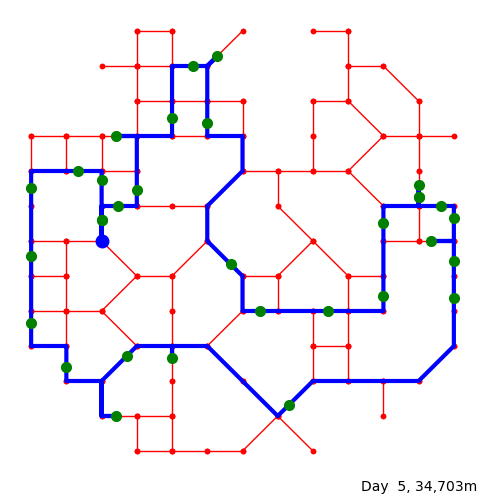

[ 5] 18:25:50.0 Driver leaves for delivery of 31 parcels
[ 5] 18:25:50.0 Driver drives to Customer: 20 (1760, 4337)
[ 5] 18:27:10.8 Driver arrived at Customer: 20 (1760, 4337)
[ 5] 18:28:11.1 Customer: 20 (1760, 4337) answers door
[ 5] 18:28:11.1 Customer: 20 (1760, 4337) accepts Parcel: 130 ( 20)
[ 5] 18:28:16.3 Customer: 20 (1760, 4337) signs off
[ 5] 18:28:23.2 Driver drives to Customer: 28 (2017, 4560)
[ 5] 18:30:18.4 Driver arrived at Customer: 28 (2017, 4560)
[ 5] 18:30:43.9 Customer: 28 (2017, 4560) answers door
[ 5] 18:30:43.9 Customer: 28 (2017, 4560) accepts Parcel: 134 ( 28)
[ 5] 18:30:54.5 Customer: 28 (2017, 4560) signs off
[ 5] 18:30:59.2 Driver drives to Customer: 34 (2320, 4813)
[ 5] 18:33:12.7 Driver arrived at Customer: 34 (2320, 4813)
[ 5] 18:34:51.7 Customer: 34 (2320, 4813) answers door
[ 5] 18:34:51.7 Customer: 34 (2320, 4813) accepts Parcel: 136 ( 34)
[ 5] 18:34:57.3 Customer: 34 (2320, 4813) signs off
[ 5] 18:35:01.8 Driver drives to Customer: 25 (1990, 5680)
[ 

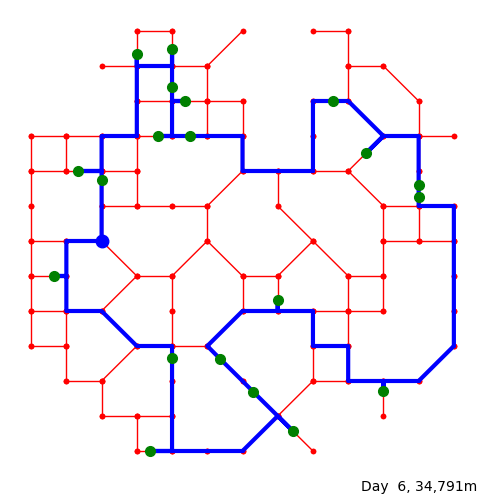

[ 6] 18:19:10.0 Driver leaves for delivery of 23 parcels
[ 6] 18:19:10.0 Driver drives to Customer: 22 (1760, 4978)
[ 6] 18:23:04.7 Driver arrived at Customer: 22 (1760, 4978)
[ 6] 18:23:09.1 Customer: 22 (1760, 4978) answers door
[ 6] 18:23:09.1 Customer: 22 (1760, 4978) accepts Parcel: 155 ( 22)
[ 6] 18:23:33.3 Customer: 22 (1760, 4978) signs off
[ 6] 18:23:34.7 Driver drives to Customer: 18 (1390, 5120)
[ 6] 18:25:37.5 Driver arrived at Customer: 18 (1390, 5120)
[ 6] 18:27:07.0 Customer: 18 (1390, 5120) answers door
[ 6] 18:27:07.0 Customer: 18 (1390, 5120) accepts Parcel: 154 ( 18)
[ 6] 18:27:13.4 Customer: 18 (1390, 5120) signs off
[ 6] 18:27:19.4 Driver drives to Customer: 38 (2320, 6990)
[ 6] 18:38:31.4 Driver arrived at Customer: 38 (2320, 6990)
[ 6] 18:38:48.1 Customer: 38 (2320, 6990) answers door
[ 6] 18:38:48.1 Customer: 38 (2320, 6990) accepts Parcel: 156 ( 38)
[ 6] 18:38:53.4 Customer: 38 (2320, 6990) signs off
[ 6] 18:38:58.2 Driver drives to Customer: 55 (2880, 7072)
[ 

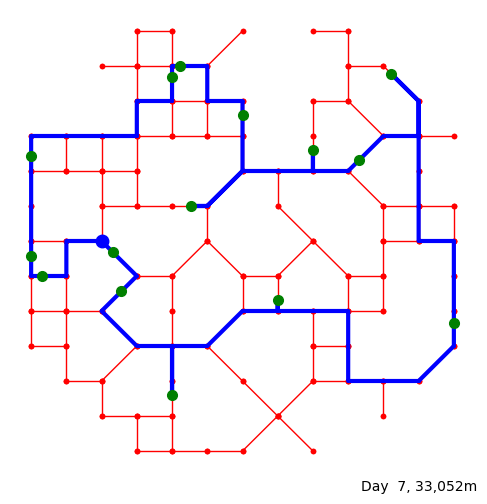

[ 7] 18:12:30.0 Driver leaves for delivery of 15 parcels
[ 7] 18:12:30.0 Driver drives to Customer:  8 (814, 3440)
[ 7] 18:18:31.4 Driver arrived at Customer:  8 (814, 3440)
[ 7] 18:18:41.0 Customer:  8 (814, 3440) answers door
[ 7] 18:18:41.0 Customer:  8 (814, 3440) accepts Parcel: 177 (  8)
[ 7] 18:18:46.8 Customer:  8 (814, 3440) signs off
[ 7] 18:18:49.6 Driver drives to Customer:  4 (640, 3757)
[ 7] 18:20:47.4 Driver arrived at Customer:  4 (640, 3757)
[ 7] 18:22:21.6 Customer:  4 (640, 3757) answers door
[ 7] 18:22:21.6 Customer:  4 (640, 3757) accepts Parcel: 175 (  4)
[ 7] 18:22:40.1 Customer:  4 (640, 3757) signs off
[ 7] 18:22:48.2 Driver drives to Customer:  6 (640, 5353)
[ 7] 18:29:11.3 Driver arrived at Customer:  6 (640, 5353)
[ 7] 18:29:20.0 Customer:  6 (640, 5353) answers door
[ 7] 18:29:20.0 Customer:  6 (640, 5353) accepts Parcel: 176 (  6)
[ 7] 18:29:20.5 Customer:  6 (640, 5353) signs off
[ 7] 18:29:21.9 Driver drives to Customer: 54 (2880, 6620)
[ 7] 18:43:23.6 D

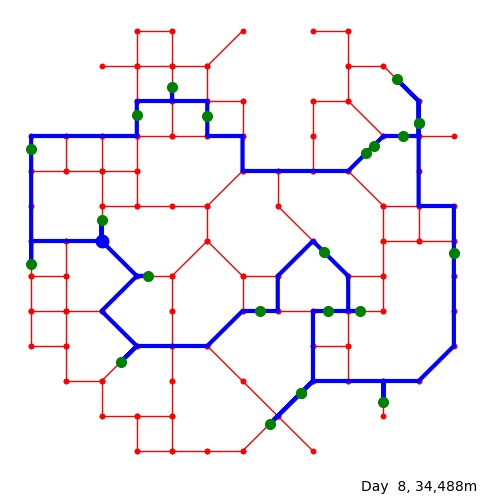

[ 8] 18:18:20.0 Driver leaves for delivery of 22 parcels
[ 8] 18:18:20.0 Driver drives to Customer: 42 (2491, 3440)
[ 8] 18:22:10.8 Driver arrived at Customer: 42 (2491, 3440)
[ 8] 18:22:11.0 Customer: 42 (2491, 3440) answers door
[ 8] 18:22:11.0 Customer: 42 (2491, 3440) accepts Parcel: 195 ( 42)
[ 8] 18:23:06.3 Customer: 42 (2491, 3440) signs off
[ 8] 18:23:07.8 Driver drives to Customer: 29 (2069, 2069)
[ 8] 18:31:33.5 Driver arrived at Customer: 29 (2069, 2069)
[ 8] 18:32:14.7 Customer: 29 (2069, 2069) answers door
[ 8] 18:32:14.7 Customer: 29 (2069, 2069) accepts Parcel: 193 ( 29)
[ 8] 18:32:21.4 Customer: 29 (2069, 2069) signs off
[ 8] 18:32:26.2 Driver drives to Customer: 83 (4274, 2880)
[ 8] 18:42:35.6 Driver arrived at Customer: 83 (4274, 2880)
[ 8] 18:43:06.4 Customer: 83 (4274, 2880) answers door
[ 8] 18:43:06.4 Customer: 83 (4274, 2880) accepts Parcel: 198 ( 83)
[ 8] 18:43:07.2 Customer: 83 (4274, 2880) signs off
[ 8] 18:43:42.3 Driver drives to Customer: 101 (5291, 3828)
[

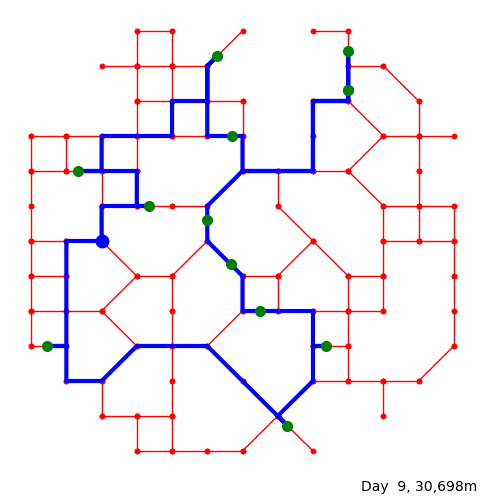

[ 9] 18:10:50.0 Driver leaves for delivery of 13 parcels
[ 9] 18:10:50.0 Driver drives to Customer: 43 (2519, 4560)
[ 9] 18:12:00.3 Parcel: 224 (113) arr at delivery centre
==== t: 187.94s Δt:   0.08s [addTarget]
createTables:     0.08s
createLoopH:      0.08s
==== t: 188.02s Δt:   0.08s [createLoopH]
[ 9] 18:12:04.0 Parcel: 225 (138) arr at delivery centre
==== t: 188.02s Δt:   0.00s [addTarget]
createTables:     0.08s
createLoopH:      0.08s
==== t: 188.11s Δt:   0.08s [createLoopH]
[ 9] 18:16:06.5 Driver arrived at Customer: 43 (2519, 4560)
[ 9] 18:16:22.6 Customer: 43 (2519, 4560) answers door
[ 9] 18:16:22.6 Customer: 43 (2519, 4560) accepts Parcel: 213 ( 43)
[ 9] 18:16:26.8 Customer: 43 (2519, 4560) signs off
[ 9] 18:17:20.1 Driver drives to Customer: 18 (1390, 5120)
[ 9] 18:24:05.5 Driver arrived at Customer: 18 (1390, 5120)
[ 9] 18:24:43.5 Customer: 18 (1390, 5120) answers door
[ 9] 18:24:43.5 Customer: 18 (1390, 5120) accepts Parcel: 212 ( 18)
[ 9] 18:24:48.9 Customer: 18 (139

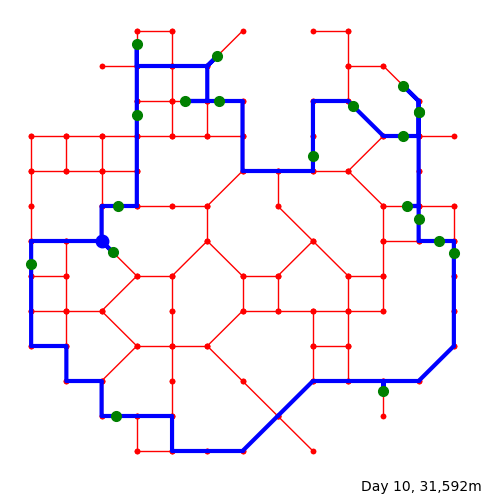

[10] 18:16:40.0 Driver leaves for delivery of 20 parcels
[10] 18:16:40.0 Driver drives to Customer: 24 (1935, 3824)
[10] 18:17:39.5 Driver arrived at Customer: 24 (1935, 3824)
[10] 18:17:54.2 Customer: 24 (1935, 3824) answers door
[10] 18:17:54.2 Customer: 24 (1935, 3824) accepts Parcel: 228 ( 24)
[10] 18:18:06.5 Customer: 24 (1935, 3824) signs off
[10] 18:18:36.5 Driver drives to Customer: 28 (2017, 4560)
[10] 18:22:52.1 Driver arrived at Customer: 28 (2017, 4560)
[10] 18:22:53.5 Customer: 28 (2017, 4560) answers door
[10] 18:22:53.5 Customer: 28 (2017, 4560) accepts Parcel: 230 ( 28)
[10] 18:23:02.9 Customer: 28 (2017, 4560) signs off
[10] 18:23:06.4 Driver drives to Customer: 36 (2320, 6014)
[10] 18:30:08.1 Driver arrived at Customer: 36 (2320, 6014)
[10] 18:30:13.0 Customer: 36 (2320, 6014) answers door
[10] 18:30:13.0 Customer: 36 (2320, 6014) accepts Parcel: 231 ( 36)
[10] 18:30:25.4 Customer: 36 (2320, 6014) signs off
[10] 18:31:04.1 Driver drives to Customer: 39 (2320, 7159)
[1

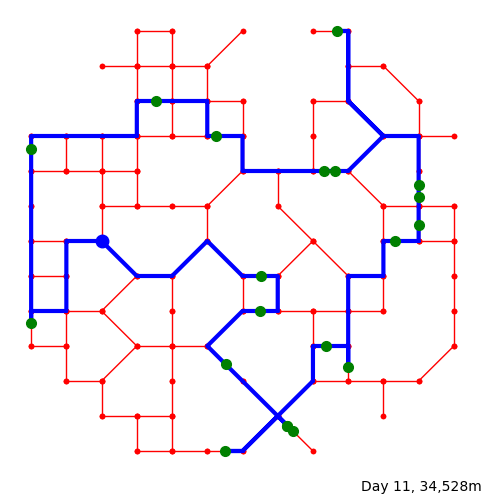

[11] 18:18:20.0 Driver leaves for delivery of 22 parcels
[11] 18:18:20.0 Driver drives to Customer: 84 (4293, 3440)
[11] 18:31:14.2 Driver arrived at Customer: 84 (4293, 3440)
[11] 18:31:44.0 Customer: 84 (4293, 3440) answers door
[11] 18:31:44.0 Customer: 84 (4293, 3440) accepts Parcel: 252 ( 84)
[11] 18:31:45.3 Customer: 84 (4293, 3440) accepts Parcel: 253 ( 84)
[11] 18:31:48.2 Customer: 84 (4293, 3440) signs off
[11] 18:31:51.5 Driver drives to Customer: 83 (4274, 2880)
[11] 18:36:18.6 Driver arrived at Customer: 83 (4274, 2880)
[11] 18:36:39.3 Customer: 83 (4274, 2880) answers door
[11] 18:36:39.3 Customer: 83 (4274, 2880) accepts Parcel: 251 ( 83)
[11] 18:36:45.7 Customer: 83 (4274, 2880) signs off
[11] 18:37:13.3 Driver drives to Customer: 72 (3733, 2026)
[11] 18:43:08.5 Driver arrived at Customer: 72 (3733, 2026)
[11] 18:43:10.9 Customer: 72 (3733, 2026) answers door
[11] 18:43:10.9 Customer: 72 (3733, 2026) accepts Parcel: 250 ( 72)
[11] 18:43:23.2 Customer: 72 (3733, 2026) sig

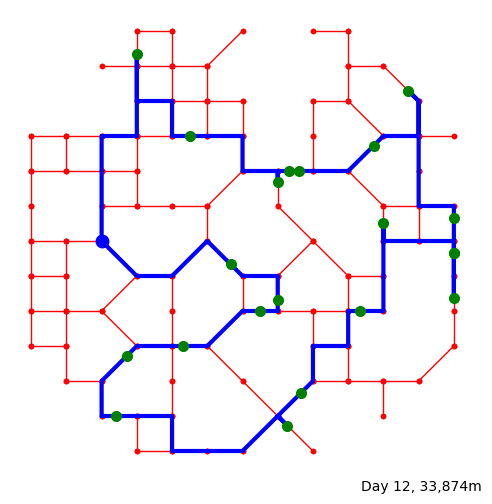

[12] 18:16:40.0 Driver leaves for delivery of 20 parcels
[12] 18:16:40.0 Driver drives to Customer: 38 (2320, 6990)
[12] 18:30:51.9 Driver arrived at Customer: 38 (2320, 6990)
[12] 18:31:01.4 Customer: 38 (2320, 6990) answers door
[12] 18:31:01.4 Customer: 38 (2320, 6990) accepts Parcel: 269 ( 38)
[12] 18:31:01.8 Customer: 38 (2320, 6990) signs off
[12] 18:31:21.1 Driver drives to Customer: 59 (3173, 5680)
[12] 18:40:00.2 Driver arrived at Customer: 59 (3173, 5680)
[12] 18:40:28.9 Customer: 59 (3173, 5680) answers door
[12] 18:40:28.9 Customer: 59 (3173, 5680) accepts Parcel: 271 ( 59)
[12] 18:40:29.5 Customer: 59 (3173, 5680) signs off
[12] 18:40:35.5 Driver drives to Customer: 89 (4560, 4946)
[12] 18:49:04.5 Driver arrived at Customer: 89 (4560, 4946)
[12] 18:49:28.5 Customer: 89 (4560, 4946) answers door
[12] 18:49:28.5 Customer: 89 (4560, 4946) accepts Parcel: 275 ( 89)
[12] 18:49:43.5 Customer: 89 (4560, 4946) signs off
[12] 18:49:57.8 Driver drives to Customer: 93 (4740, 5120)
[1

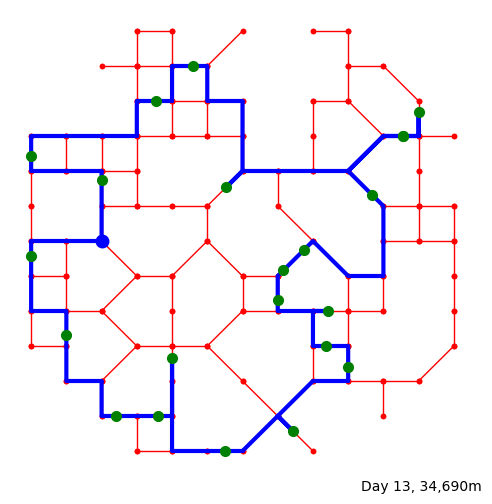

[13] 18:17:30.0 Driver leaves for delivery of 21 parcels
[13] 18:17:30.0 Driver drives to Customer:  4 (640, 3757)
[13] 18:22:57.1 Driver arrived at Customer:  4 (640, 3757)
[13] 18:23:06.1 Customer:  4 (640, 3757) answers door
[13] 18:23:06.1 Customer:  4 (640, 3757) accepts Parcel: 286 (  4)
[13] 18:23:07.1 Customer:  4 (640, 3757) signs off
[13] 18:23:10.1 Driver drives to Customer: 15 (1200, 2503)
[13] 18:30:25.5 Driver arrived at Customer: 15 (1200, 2503)
[13] 18:31:28.6 Customer: 15 (1200, 2503) answers door
[13] 18:31:28.6 Customer: 15 (1200, 2503) accepts Parcel: 288 ( 15)
[13] 18:31:28.7 Customer: 15 (1200, 2503) signs off
[13] 18:31:49.3 Driver drives to Customer: 26 (1994, 1200)
[13] 18:40:12.6 Driver arrived at Customer: 26 (1994, 1200)
[13] 18:42:04.9 Customer: 26 (1994, 1200) answers door
[13] 18:42:04.9 Customer: 26 (1994, 1200) accepts Parcel: 290 ( 26)
[13] 18:42:06.9 Customer: 26 (1994, 1200) signs off
[13] 18:42:08.8 Driver drives to Customer: 47 (2653, 1200)
[13] 18

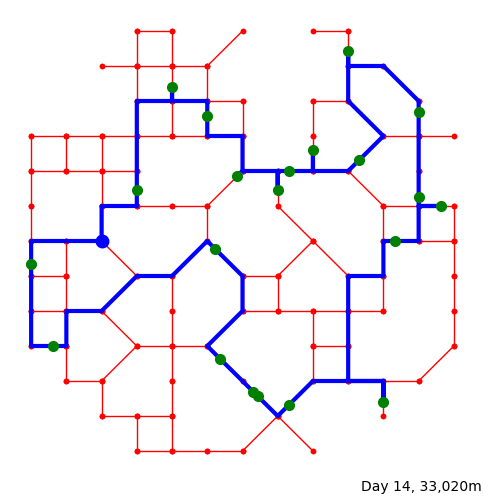

[14] 18:20:50.0 Driver leaves for delivery of 25 parcels
[14] 18:20:50.0 Driver drives to Customer:  3 (640, 3632)
[14] 18:26:47.1 Driver arrived at Customer:  3 (640, 3632)
[14] 18:28:17.5 Customer:  3 (640, 3632) answers door
[14] 18:28:17.5 Customer:  3 (640, 3632) accepts Parcel: 308 (  3)
[14] 18:28:18.3 Customer:  3 (640, 3632) signs off
[14] 18:28:34.6 Driver drives to Customer: 12 (993, 2320)
[14] 18:35:14.2 Driver arrived at Customer: 12 (993, 2320)
[14] 18:35:21.2 Customer: 12 (993, 2320) answers door
[14] 18:35:21.2 Customer: 12 (993, 2320) accepts Parcel: 309 ( 12)
[14] 18:35:22.3 Customer: 12 (993, 2320) signs off
[14] 18:35:25.3 Driver drives to Customer: 66 (3566, 3872)
[14] 18:50:00.9 Driver arrived at Customer: 66 (3566, 3872)
[14] 18:50:51.0 Customer: 66 (3566, 3872) answers door
[14] 18:50:51.0 Customer: 66 (3566, 3872) accepts Parcel: 314 ( 66)
[14] 18:51:00.4 Customer: 66 (3566, 3872) accepts Parcel: 315 ( 66)
[14] 18:51:05.9 Customer: 66 (3566, 3872) signs off
[14

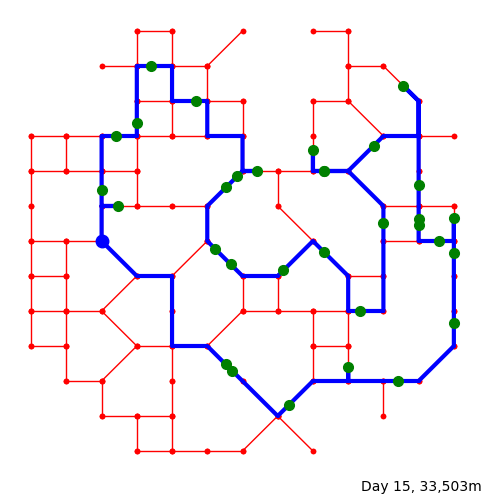

[15] 18:26:40.0 Driver leaves for delivery of 32 parcels
[15] 18:26:40.0 Driver drives to Customer: 28 (2017, 4560)
[15] 18:29:56.0 Driver arrived at Customer: 28 (2017, 4560)
[15] 18:30:16.7 Customer: 28 (2017, 4560) answers door
[15] 18:30:16.7 Customer: 28 (2017, 4560) accepts Parcel: 334 ( 28)
[15] 18:30:16.8 Customer: 28 (2017, 4560) signs off
[15] 18:30:26.9 Driver drives to Customer: 21 (1760, 4812)
[15] 18:32:29.0 Driver arrived at Customer: 21 (1760, 4812)
[15] 18:32:31.2 Customer: 21 (1760, 4812) answers door
[15] 18:32:31.2 Customer: 21 (1760, 4812) accepts Parcel: 332 ( 21)
[15] 18:32:46.0 Customer: 21 (1760, 4812) signs off
[15] 18:32:46.7 Driver drives to Customer: 25 (1990, 5680)
[15] 18:37:10.3 Driver arrived at Customer: 25 (1990, 5680)
[15] 18:37:10.7 Customer: 25 (1990, 5680) answers door
[15] 18:37:10.7 Customer: 25 (1990, 5680) accepts Parcel: 333 ( 25)
[15] 18:37:14.0 Customer: 25 (1990, 5680) signs off
[15] 18:37:28.8 Driver drives to Customer: 35 (2320, 5885)
[1

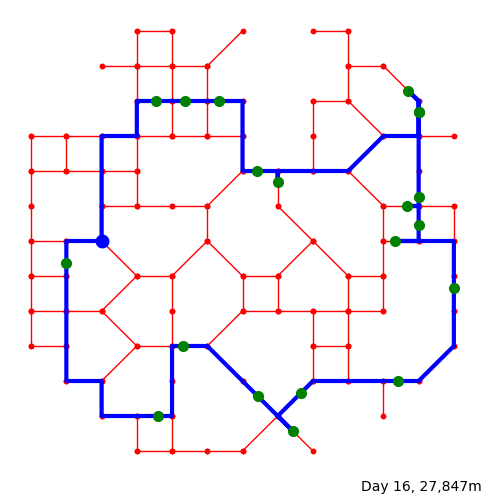

[16] 18:16:40.0 Driver leaves for delivery of 20 parcels
[16] 18:16:40.0 Driver drives to Customer: 17 (1200, 3643)
[16] 18:20:20.0 Driver arrived at Customer: 17 (1200, 3643)
[16] 18:21:09.2 Customer: 17 (1200, 3643) answers door
[16] 18:21:09.2 Customer: 17 (1200, 3643) accepts Parcel: 364 ( 17)
[16] 18:22:16.5 Customer: 17 (1200, 3643) signs off
[16] 18:22:25.6 Driver drives to Customer: 47 (2653, 1200)
[16] 18:38:00.7 Driver arrived at Customer: 47 (2653, 1200)
[16] 18:40:30.1 Customer: 47 (2653, 1200) answers door
[16] 18:40:30.1 Customer: 47 (2653, 1200) accepts Parcel: 366 ( 47)
[16] 18:40:32.0 Customer: 47 (2653, 1200) signs off
[16] 18:40:37.8 Driver drives to Customer: 57 (3051, 2320)
[16] 18:46:42.2 Driver arrived at Customer: 57 (3051, 2320)
[16] 18:47:16.7 Customer: 57 (3051, 2320) answers door
[16] 18:47:16.7 Customer: 57 (3051, 2320) accepts Parcel: 367 ( 57)
[16] 18:47:55.0 Customer: 57 (3051, 2320) signs off
[16] 18:48:03.4 Driver drives to Customer: 82 (4244, 1515)
[1

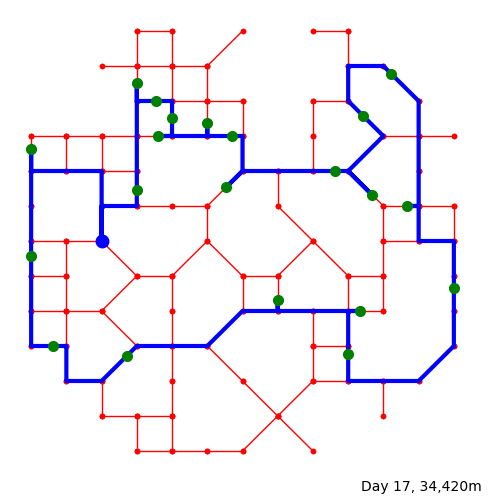

[17] 18:20:50.0 Driver leaves for delivery of 25 parcels
[17] 18:20:50.0 Driver drives to Customer: 34 (2320, 4813)
[17] 18:26:19.5 Driver arrived at Customer: 34 (2320, 4813)
[17] 18:26:38.9 Customer: 34 (2320, 4813) answers door
[17] 18:26:38.9 Customer: 34 (2320, 4813) accepts Parcel: 388 ( 34)
[17] 18:26:58.8 Customer: 34 (2320, 4813) signs off
[17] 18:27:00.1 Driver drives to Customer: 37 (2320, 6528)
[17] 18:33:51.7 Driver arrived at Customer: 37 (2320, 6528)
[17] 18:33:54.1 Customer: 37 (2320, 6528) answers door
[17] 18:33:54.1 Customer: 37 (2320, 6528) accepts Parcel: 389 ( 37)
[17] 18:34:34.9 Customer: 37 (2320, 6528) signs off
[17] 18:34:49.3 Driver drives to Customer: 46 (2629, 6240)
[17] 18:37:12.6 Driver arrived at Customer: 46 (2629, 6240)
[17] 18:37:50.8 Customer: 46 (2629, 6240) answers door
[17] 18:37:50.8 Customer: 46 (2629, 6240) accepts Parcel: 390 ( 46)
[17] 18:37:59.0 Customer: 46 (2629, 6240) signs off
[17] 18:38:02.7 Driver drives to Customer: 52 (2880, 5961)
[1

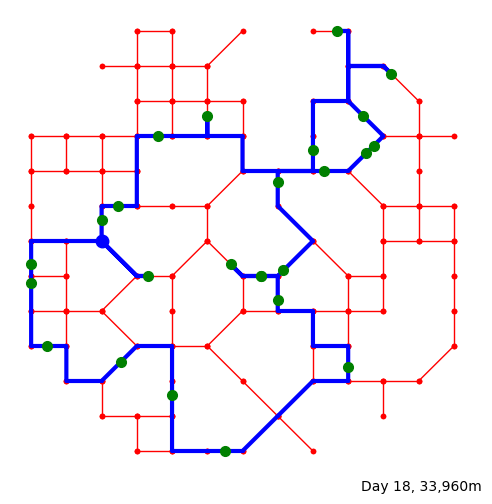

[18] 18:20:50.0 Driver leaves for delivery of 25 parcels
[18] 18:20:50.0 Driver drives to Customer: 42 (2491, 3440)
[18] 18:24:40.8 Driver arrived at Customer: 42 (2491, 3440)
[18] 18:25:34.2 Customer: 42 (2491, 3440) answers door
[18] 18:25:34.2 Customer: 42 (2491, 3440) accepts Parcel: 415 ( 42)
[18] 18:25:34.2 Customer: 42 (2491, 3440) signs off
[18] 18:25:35.8 Driver drives to Customer:  3 (640, 3632)
[18] 18:35:23.8 Driver arrived at Customer:  3 (640, 3632)
[18] 18:35:33.0 Customer:  3 (640, 3632) answers door
[18] 18:35:33.0 Customer:  3 (640, 3632) accepts Parcel: 410 (  3)
[18] 18:35:41.7 Customer:  3 (640, 3632) signs off
[18] 18:35:41.7 Driver drives to Customer:  2 (640, 3330)
[18] 18:36:54.2 Driver arrived at Customer:  2 (640, 3330)
[18] 18:36:59.6 Customer:  2 (640, 3330) answers door
[18] 18:36:59.6 Customer:  2 (640, 3330) accepts Parcel: 409 (  2)
[18] 18:37:06.3 Customer:  2 (640, 3330) signs off
[18] 18:37:06.7 Driver drives to Customer:  9 (886, 2320)
[18] 18:42:08

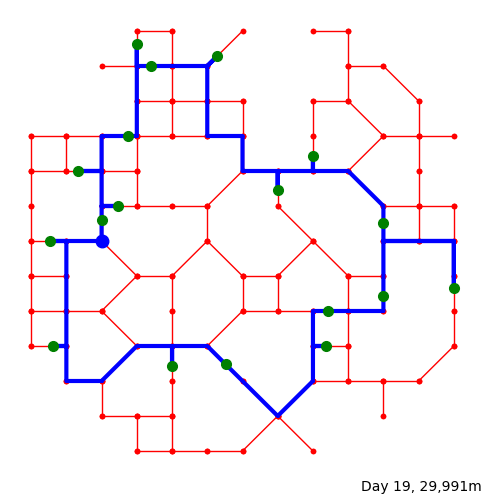

[19] 18:15:00.0 Driver leaves for delivery of 18 parcels
[19] 18:15:00.0 Driver drives to Customer: 20 (1760, 4337)
[19] 18:16:20.8 Driver arrived at Customer: 20 (1760, 4337)
[19] 18:18:04.3 Customer: 20 (1760, 4337) answers door
[19] 18:18:04.3 Customer: 20 (1760, 4337) accepts Parcel: 437 ( 20)
[19] 18:18:05.3 Customer: 20 (1760, 4337) signs off
[19] 18:18:06.7 Driver drives to Customer: 28 (2017, 4560)
[19] 18:20:01.9 Driver arrived at Customer: 28 (2017, 4560)
[19] 18:20:10.6 Customer: 28 (2017, 4560) answers door
[19] 18:20:10.6 Customer: 28 (2017, 4560) accepts Parcel: 438 ( 28)
[19] 18:20:19.2 Customer: 28 (2017, 4560) signs off
[19] 18:20:29.4 Driver drives to Customer: 18 (1390, 5120)
[19] 18:25:14.3 Driver arrived at Customer: 18 (1390, 5120)
[19] 18:25:36.9 Customer: 18 (1390, 5120) answers door
[19] 18:25:36.9 Customer: 18 (1390, 5120) accepts Parcel: 436 ( 18)
[19] 18:25:41.9 Customer: 18 (1390, 5120) signs off
[19] 18:25:52.2 Driver drives to Customer: 33 (2180, 5680)
[1

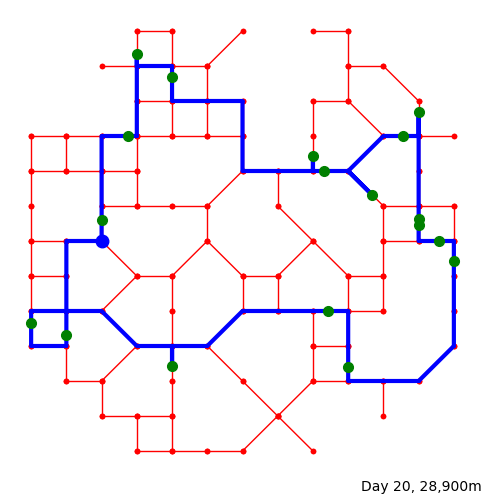

[20] 18:16:40.0 Driver leaves for delivery of 20 parcels
[20] 18:16:40.0 Driver drives to Customer: 20 (1760, 4337)
[20] 18:18:00.8 Driver arrived at Customer: 20 (1760, 4337)
[20] 18:21:30.4 Customer: 20 (1760, 4337) answers door
[20] 18:21:30.4 Customer: 20 (1760, 4337) accepts Parcel: 454 ( 20)
[20] 18:21:37.8 Customer: 20 (1760, 4337) signs off
[20] 18:21:43.3 Driver drives to Customer: 33 (2180, 5680)
[20] 18:28:46.5 Driver arrived at Customer: 33 (2180, 5680)
[20] 18:29:38.2 Customer: 33 (2180, 5680) answers door
[20] 18:29:38.2 Customer: 33 (2180, 5680) accepts Parcel: 455 ( 33)
[20] 18:29:42.9 Customer: 33 (2180, 5680) signs off
[20] 18:29:43.3 Driver drives to Customer: 38 (2320, 6990)
[20] 18:35:31.3 Driver arrived at Customer: 38 (2320, 6990)
[20] 18:35:54.6 Customer: 38 (2320, 6990) answers door
[20] 18:35:54.6 Customer: 38 (2320, 6990) accepts Parcel: 456 ( 38)
[20] 18:35:58.0 Customer: 38 (2320, 6990) signs off
[20] 18:36:08.8 Driver drives to Customer: 54 (2880, 6620)
[2

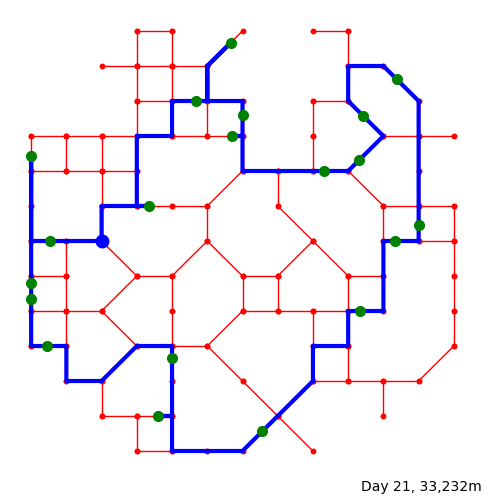

[21] 18:19:10.0 Driver leaves for delivery of 23 parcels
[21] 18:19:10.0 Driver drives to Customer: 43 (2519, 4560)
[21] 18:24:26.5 Driver arrived at Customer: 43 (2519, 4560)
[21] 18:25:35.4 Customer: 43 (2519, 4560) answers door
[21] 18:25:35.4 Customer: 43 (2519, 4560) accepts Parcel: 478 ( 43)
[21] 18:25:45.1 Customer: 43 (2519, 4560) signs off
[21] 18:25:45.8 Driver drives to Customer: 62 (3262, 6240)
[21] 18:37:02.8 Driver arrived at Customer: 62 (3262, 6240)
[21] 18:37:15.9 Customer: 62 (3262, 6240) answers door
[21] 18:37:15.9 Customer: 62 (3262, 6240) accepts Parcel: 481 ( 62)
[21] 18:37:19.1 Customer: 62 (3262, 6240) signs off
[21] 18:37:25.4 Driver drives to Customer: 75 (3816, 7176)
[21] 18:42:29.9 Driver arrived at Customer: 75 (3816, 7176)
[21] 18:43:30.5 Customer: 75 (3816, 7176) answers door
[21] 18:43:30.5 Customer: 75 (3816, 7176) accepts Parcel: 482 ( 75)
[21] 18:43:39.1 Customer: 75 (3816, 7176) signs off
[21] 18:44:27.4 Driver drives to Customer: 79 (4000, 6010)
[2

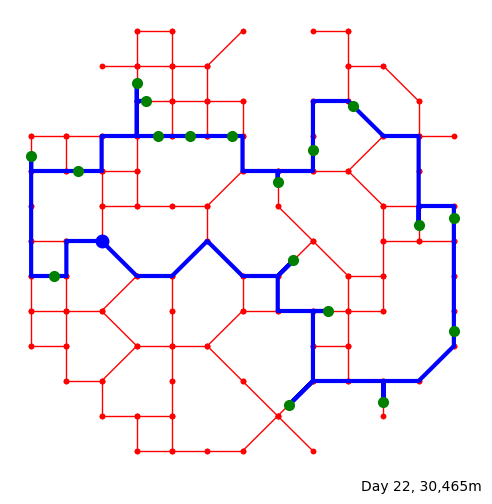

[22] 18:15:00.0 Driver leaves for delivery of 18 parcels
[22] 18:15:00.0 Driver drives to Customer: 13 (1008, 3440)
[22] 18:20:14.8 Driver arrived at Customer: 13 (1008, 3440)
[22] 18:20:42.3 Customer: 13 (1008, 3440) answers door
[22] 18:20:42.3 Customer: 13 (1008, 3440) accepts Parcel: 496 ( 13)
[22] 18:21:12.4 Customer: 13 (1008, 3440) signs off
[22] 18:21:14.3 Driver drives to Customer:  6 (640, 5353)
[22] 18:30:21.7 Driver arrived at Customer:  6 (640, 5353)
[22] 18:30:22.4 Customer:  6 (640, 5353) answers door
[22] 18:30:22.4 Customer:  6 (640, 5353) accepts Parcel: 495 (  6)
[22] 18:30:26.5 Customer:  6 (640, 5353) signs off
[22] 18:30:38.8 Driver drives to Customer: 18 (1390, 5120)
[22] 18:34:34.7 Driver arrived at Customer: 18 (1390, 5120)
[22] 18:35:53.6 Customer: 18 (1390, 5120) answers door
[22] 18:35:53.6 Customer: 18 (1390, 5120) accepts Parcel: 497 ( 18)
[22] 18:35:54.8 Customer: 18 (1390, 5120) signs off
[22] 18:35:55.1 Driver drives to Customer: 37 (2320, 6528)
[22] 18

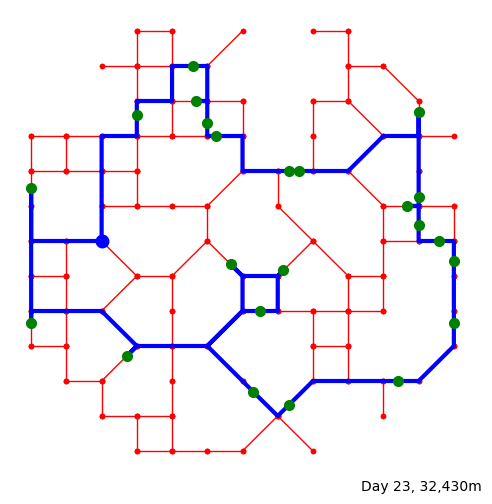

[23] 18:20:50.0 Driver leaves for delivery of 25 parcels
[23] 18:20:50.0 Driver drives to Customer:  5 (640, 4856)
[23] 18:28:44.2 Driver arrived at Customer:  5 (640, 4856)
[23] 18:29:04.6 Customer:  5 (640, 4856) answers door
[23] 18:29:04.6 Customer:  5 (640, 4856) accepts Parcel: 514 (  5)
[23] 18:29:05.7 Customer:  5 (640, 4856) signs off
[23] 18:29:06.9 Driver drives to Customer:  0 (640, 2695)
[23] 18:37:45.5 Driver arrived at Customer:  0 (640, 2695)
[23] 18:38:37.1 Customer:  0 (640, 2695) answers door
[23] 18:38:37.1 Customer:  0 (640, 2695) accepts Parcel: 513 (  0)
[23] 18:38:40.9 Customer:  0 (640, 2695) signs off
[23] 18:38:42.1 Driver drives to Customer: 32 (2164, 2164)
[23] 18:47:57.9 Driver arrived at Customer: 32 (2164, 2164)
[23] 18:48:58.2 Customer: 32 (2164, 2164) answers door
[23] 18:48:58.2 Customer: 32 (2164, 2164) accepts Parcel: 515 ( 32)
[23] 18:49:20.1 Customer: 32 (2164, 2164) signs off
[23] 18:49:21.2 Driver drives to Customer: 74 (3812, 3627)
[23] 19:01:1

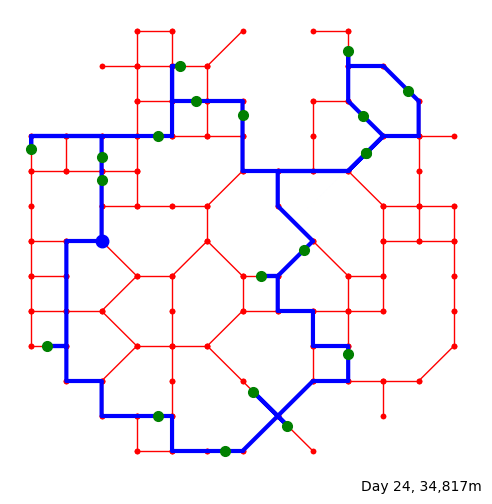

[24] 18:16:40.0 Driver leaves for delivery of 20 parcels
[24] 18:16:40.0 Driver drives to Customer: 22 (1760, 4978)
[24] 18:20:34.7 Driver arrived at Customer: 22 (1760, 4978)
[24] 18:21:08.2 Customer: 22 (1760, 4978) answers door
[24] 18:21:08.2 Customer: 22 (1760, 4978) accepts Parcel: 540 ( 22)
[24] 18:21:08.9 Customer: 22 (1760, 4978) signs off
[24] 18:21:57.2 Driver drives to Customer: 23 (1760, 5352)
[24] 18:23:26.9 Driver arrived at Customer: 23 (1760, 5352)
[24] 18:24:10.0 Customer: 23 (1760, 5352) answers door
[24] 18:24:10.0 Customer: 23 (1760, 5352) accepts Parcel: 541 ( 23)
[24] 18:24:22.7 Customer: 23 (1760, 5352) signs off
[24] 18:24:34.6 Driver drives to Customer:  7 (640, 5473)
[24] 18:31:11.8 Driver arrived at Customer:  7 (640, 5473)
[24] 18:33:05.0 Customer:  7 (640, 5473) answers door
[24] 18:33:05.0 Customer:  7 (640, 5473) accepts Parcel: 538 (  7)
[24] 18:33:10.2 Customer:  7 (640, 5473) signs off
[24] 18:33:13.4 Driver drives to Customer: 48 (2664, 5680)
[24] 18

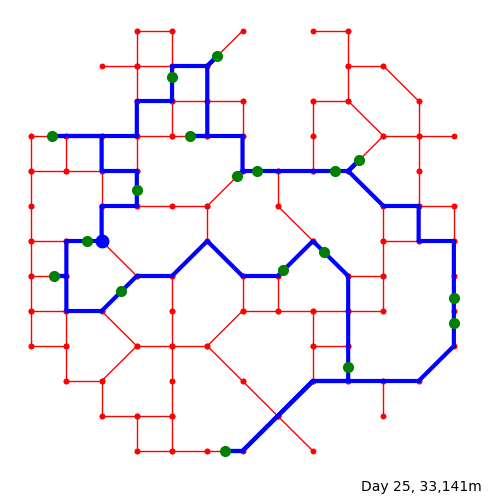

[25] 18:15:00.0 Driver leaves for delivery of 18 parcels
[25] 18:15:00.0 Driver drives to Customer: 19 (1522, 4000)
[25] 18:15:57.1 Driver arrived at Customer: 19 (1522, 4000)
[25] 18:16:16.0 Customer: 19 (1522, 4000) answers door
[25] 18:16:16.0 Customer: 19 (1522, 4000) accepts Parcel: 562 ( 19)
[25] 18:16:25.8 Customer: 19 (1522, 4000) signs off
[25] 18:16:27.5 Driver drives to Customer: 13 (1008, 3440)
[25] 18:20:45.2 Driver arrived at Customer: 13 (1008, 3440)
[25] 18:21:54.2 Customer: 13 (1008, 3440) answers door
[25] 18:21:54.2 Customer: 13 (1008, 3440) accepts Parcel: 561 ( 13)
[25] 18:22:01.1 Customer: 13 (1008, 3440) signs off
[25] 18:22:01.8 Driver drives to Customer: 30 (2074, 3194)
[25] 18:29:03.3 Driver arrived at Customer: 30 (2074, 3194)
[25] 18:29:07.5 Customer: 30 (2074, 3194) answers door
[25] 18:29:07.5 Customer: 30 (2074, 3194) accepts Parcel: 563 ( 30)
[25] 18:29:36.1 Customer: 30 (2074, 3194) signs off
[25] 18:29:36.5 Driver drives to Customer: 90 (4649, 3529)
[2

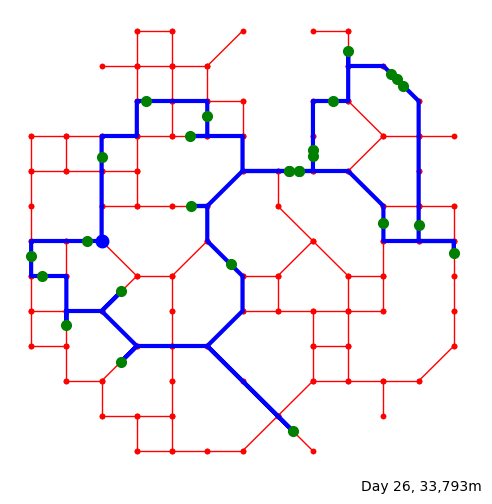

[26] 18:21:40.0 Driver leaves for delivery of 26 parcels
[26] 18:21:40.0 Driver drives to Customer: 23 (1760, 5352)
[26] 18:27:04.4 Driver arrived at Customer: 23 (1760, 5352)
[26] 18:29:02.3 Customer: 23 (1760, 5352) answers door
[26] 18:29:02.3 Customer: 23 (1760, 5352) accepts Parcel: 581 ( 23)
[26] 18:29:10.6 Customer: 23 (1760, 5352) signs off
[26] 18:29:26.4 Driver drives to Customer: 40 (2462, 6240)
[26] 18:35:48.0 Driver arrived at Customer: 40 (2462, 6240)
[26] 18:35:51.2 Customer: 40 (2462, 6240) answers door
[26] 18:35:51.2 Customer: 40 (2462, 6240) accepts Parcel: 584 ( 40)
[26] 18:35:51.9 Customer: 40 (2462, 6240) accepts Parcel: 585 ( 40)
[26] 18:36:06.9 Customer: 40 (2462, 6240) signs off
[26] 18:36:08.1 Driver drives to Customer: 65 (3440, 5996)
[26] 18:41:01.4 Driver arrived at Customer: 65 (3440, 5996)
[26] 18:42:10.2 Customer: 65 (3440, 5996) answers door
[26] 18:42:10.2 Customer: 65 (3440, 5996) accepts Parcel: 588 ( 65)
[26] 18:42:37.4 Customer: 65 (3440, 5996) sig

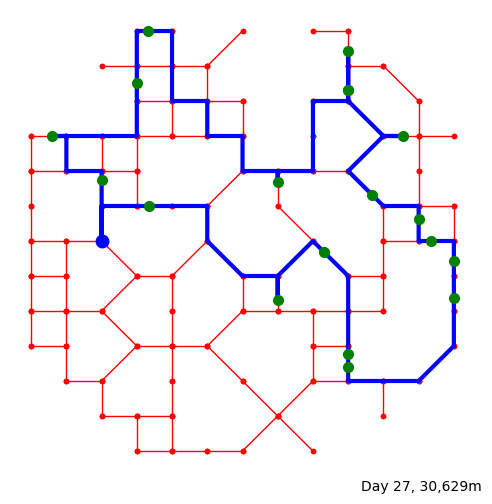

[27] 18:15:00.0 Driver leaves for delivery of 18 parcels
[27] 18:15:00.0 Driver drives to Customer: 43 (2519, 4560)
[27] 18:20:16.5 Driver arrived at Customer: 43 (2519, 4560)
[27] 18:20:36.6 Customer: 43 (2519, 4560) answers door
[27] 18:20:36.6 Customer: 43 (2519, 4560) accepts Parcel: 606 ( 43)
[27] 18:21:10.5 Customer: 43 (2519, 4560) signs off
[27] 18:21:15.9 Driver drives to Customer: 87 (4560, 3050)
[27] 18:34:09.2 Driver arrived at Customer: 87 (4560, 3050)
[27] 18:34:21.8 Customer: 87 (4560, 3050) answers door
[27] 18:34:21.8 Customer: 87 (4560, 3050) accepts Parcel: 607 ( 87)
[27] 18:34:37.9 Customer: 87 (4560, 3050) signs off
[27] 18:35:03.1 Driver drives to Customer: 101 (5291, 3828)
[27] 18:40:44.6 Driver arrived at Customer: 101 (5291, 3828)
[27] 18:40:46.5 Customer: 101 (5291, 3828) answers door
[27] 18:40:46.5 Customer: 101 (5291, 3828) accepts Parcel: 609 (101)
[27] 18:41:26.2 Customer: 101 (5291, 3828) signs off
[27] 18:41:39.0 Driver drives to Customer: 110 (5680, 21

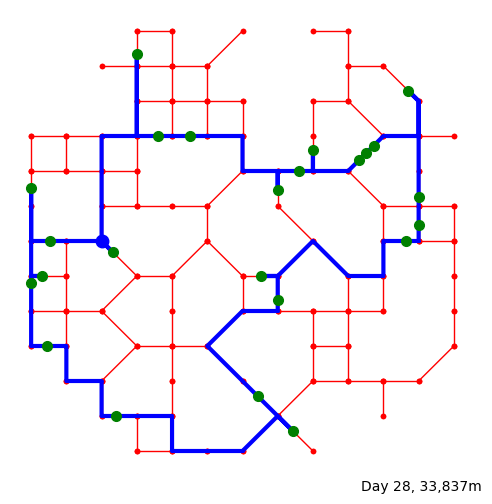

[28] 18:22:30.0 Driver leaves for delivery of 27 parcels
[28] 18:22:30.0 Driver drives to Customer: 10 (932, 4000)
[28] 18:25:48.7 Driver arrived at Customer: 10 (932, 4000)
[28] 18:26:41.6 Customer: 10 (932, 4000) answers door
[28] 18:26:41.6 Customer: 10 (932, 4000) accepts Parcel: 625 ( 10)
[28] 18:26:51.7 Customer: 10 (932, 4000) signs off
[28] 18:27:14.8 Driver drives to Customer:  5 (640, 4856)
[28] 18:31:50.4 Driver arrived at Customer:  5 (640, 4856)
[28] 18:32:42.0 Customer:  5 (640, 4856) answers door
[28] 18:32:42.0 Customer:  5 (640, 4856) accepts Parcel: 621 (  5)
[28] 18:32:52.0 Customer:  5 (640, 4856) accepts Parcel: 622 (  5)
[28] 18:33:17.3 Customer:  5 (640, 4856) signs off
[28] 18:33:31.8 Driver drives to Customer:  8 (814, 3440)
[28] 18:39:53.4 Driver arrived at Customer:  8 (814, 3440)
[28] 18:39:54.0 Customer:  8 (814, 3440) answers door
[28] 18:39:54.0 Customer:  8 (814, 3440) accepts Parcel: 623 (  8)
[28] 18:40:14.3 Customer:  8 (814, 3440) signs off
[28] 18:4

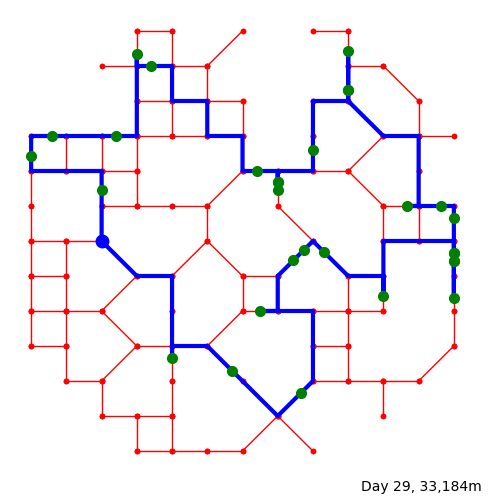

[29] 18:24:10.0 Driver leaves for delivery of 29 parcels
[29] 18:24:10.0 Driver drives to Customer: 51 (2880, 2123)
[29] 18:34:50.3 Driver arrived at Customer: 51 (2880, 2123)
[29] 18:35:13.5 Customer: 51 (2880, 2123) answers door
[29] 18:35:13.5 Customer: 51 (2880, 2123) accepts Parcel: 656 ( 51)
[29] 18:35:25.3 Customer: 51 (2880, 2123) signs off
[29] 18:35:27.0 Driver drives to Customer: 77 (3841, 1918)
[29] 18:40:44.8 Driver arrived at Customer: 77 (3841, 1918)
[29] 18:41:45.8 Customer: 77 (3841, 1918) answers door
[29] 18:41:45.8 Customer: 77 (3841, 1918) accepts Parcel: 657 ( 77)
[29] 18:42:04.5 Customer: 77 (3841, 1918) signs off
[29] 18:42:11.2 Driver drives to Customer: 97 (4927, 1567)
[29] 18:48:19.4 Driver arrived at Customer: 97 (4927, 1567)
[29] 18:49:08.8 Customer: 97 (4927, 1567) answers door
[29] 18:49:08.8 Customer: 97 (4927, 1567) accepts Parcel: 663 ( 97)
[29] 18:49:21.7 Customer: 97 (4927, 1567) accepts Parcel: 664 ( 97)
[29] 18:50:09.8 Customer: 97 (4927, 1567) sig

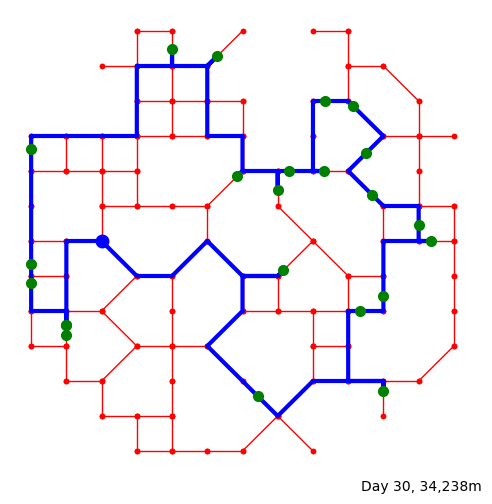

[30] 18:21:40.0 Driver leaves for delivery of 26 parcels
[30] 18:21:40.0 Driver drives to Customer: 16 (1200, 2663)
[30] 18:29:15.2 Driver arrived at Customer: 16 (1200, 2663)
[30] 18:29:23.6 Customer: 16 (1200, 2663) answers door
[30] 18:29:23.6 Customer: 16 (1200, 2663) accepts Parcel: 681 ( 16)
[30] 18:29:34.1 Customer: 16 (1200, 2663) signs off
[30] 18:29:44.3 Driver drives to Customer: 15 (1200, 2503)
[30] 18:30:22.7 Driver arrived at Customer: 15 (1200, 2503)
[30] 18:30:30.1 Customer: 15 (1200, 2503) answers door
[30] 18:30:30.1 Customer: 15 (1200, 2503) accepts Parcel: 680 ( 15)
[30] 18:30:38.3 Customer: 15 (1200, 2503) signs off
[30] 18:30:44.8 Driver drives to Customer:  2 (640, 3330)
[30] 18:36:17.6 Driver arrived at Customer:  2 (640, 3330)
[30] 18:36:28.7 Customer:  2 (640, 3330) answers door
[30] 18:36:28.7 Customer:  2 (640, 3330) accepts Parcel: 676 (  2)
[30] 18:36:41.1 Customer:  2 (640, 3330) signs off
[30] 18:37:03.7 Driver drives to Customer:  3 (640, 3632)
[30] 18:

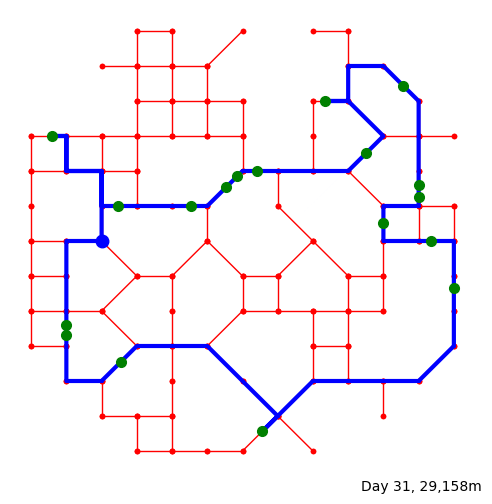

[31] 18:15:50.0 Driver leaves for delivery of 19 parcels
[31] 18:15:50.0 Driver drives to Customer: 16 (1200, 2663)
[31] 18:23:25.2 Driver arrived at Customer: 16 (1200, 2663)
[31] 18:24:08.7 Customer: 16 (1200, 2663) answers door
[31] 18:24:08.7 Customer: 16 (1200, 2663) accepts Parcel: 705 ( 16)
[31] 18:24:11.9 Customer: 16 (1200, 2663) signs off
[31] 18:24:15.4 Driver drives to Customer: 15 (1200, 2503)
[31] 18:24:53.8 Driver arrived at Customer: 15 (1200, 2503)
[31] 18:25:32.8 Customer: 15 (1200, 2503) answers door
[31] 18:25:32.8 Customer: 15 (1200, 2503) accepts Parcel: 704 ( 15)
[31] 18:25:42.5 Customer: 15 (1200, 2503) signs off
[31] 18:25:44.5 Driver drives to Customer: 29 (2069, 2069)
[31] 18:32:41.9 Driver arrived at Customer: 29 (2069, 2069)
[31] 18:32:50.6 Customer: 29 (2069, 2069) answers door
[31] 18:32:50.6 Customer: 29 (2069, 2069) accepts Parcel: 707 ( 29)
[31] 18:32:58.5 Customer: 29 (2069, 2069) signs off
[31] 18:33:16.4 Driver drives to Customer: 85 (4317, 957)
[31

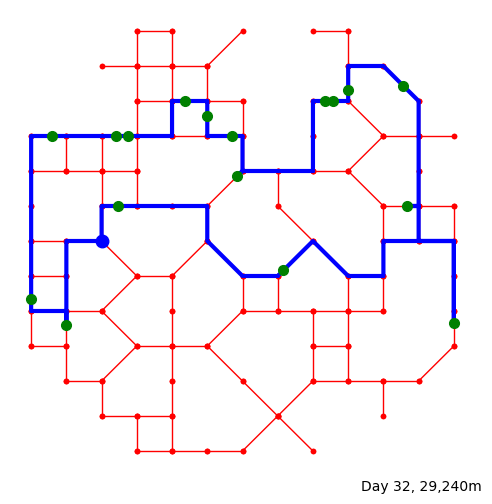

[32] 18:15:50.0 Driver leaves for delivery of 19 parcels
[32] 18:15:50.0 Driver drives to Customer: 28 (2017, 4560)
[32] 18:19:06.0 Driver arrived at Customer: 28 (2017, 4560)
[32] 18:20:05.8 Customer: 28 (2017, 4560) answers door
[32] 18:20:05.8 Customer: 28 (2017, 4560) accepts Parcel: 726 ( 28)
[32] 18:20:06.4 Customer: 28 (2017, 4560) signs off
[32] 18:20:16.5 Driver drives to Customer: 90 (4649, 3529)
[32] 18:34:06.7 Driver arrived at Customer: 90 (4649, 3529)
[32] 18:35:53.8 Customer: 90 (4649, 3529) answers door
[32] 18:35:53.8 Customer: 90 (4649, 3529) accepts Parcel: 733 ( 90)
[32] 18:36:16.0 Customer: 90 (4649, 3529) signs off
[32] 18:36:19.8 Driver drives to Customer: 144 (7360, 2693)
[32] 18:56:20.7 Driver arrived at Customer: 144 (7360, 2693)
[32] 18:56:33.9 Customer: 144 (7360, 2693) answers door
[32] 18:56:33.9 Customer: 144 (7360, 2693) accepts Parcel: 739 (144)
[32] 18:56:37.4 Customer: 144 (7360, 2693) signs off
[32] 18:56:59.2 Driver drives to Customer: 131 (6609, 45

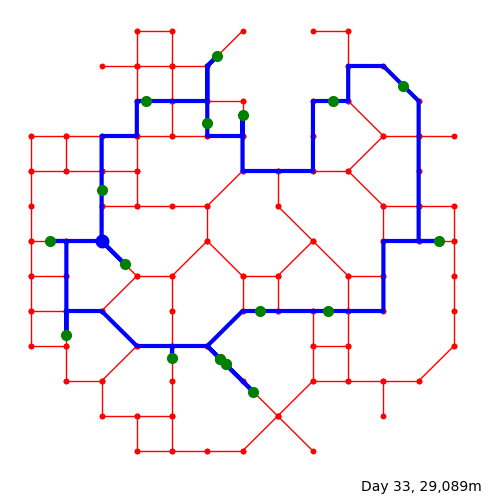

[33] 18:16:40.0 Driver leaves for delivery of 20 parcels
[33] 18:16:40.0 Driver drives to Customer: 31 (2126, 3633)
[33] 18:18:44.3 Driver arrived at Customer: 31 (2126, 3633)
[33] 18:18:48.2 Customer: 31 (2126, 3633) answers door
[33] 18:18:48.2 Customer: 31 (2126, 3633) accepts Parcel: 743 ( 31)
[33] 18:19:16.3 Customer: 31 (2126, 3633) signs off
[33] 18:19:17.8 Driver drives to Customer: 10 (932, 4000)
[33] 18:24:40.8 Driver arrived at Customer: 10 (932, 4000)
[33] 18:25:13.9 Customer: 10 (932, 4000) answers door
[33] 18:25:13.9 Customer: 10 (932, 4000) accepts Parcel: 740 ( 10)
[33] 18:25:24.3 Customer: 10 (932, 4000) signs off
[33] 18:25:28.9 Driver drives to Customer: 15 (1200, 2503)
[33] 18:32:32.5 Driver arrived at Customer: 15 (1200, 2503)
[33] 18:32:36.5 Customer: 15 (1200, 2503) answers door
[33] 18:32:36.5 Customer: 15 (1200, 2503) accepts Parcel: 741 ( 15)
[33] 18:32:43.2 Customer: 15 (1200, 2503) signs off
[33] 18:32:47.3 Driver drives to Customer: 51 (2880, 2123)
[33] 18

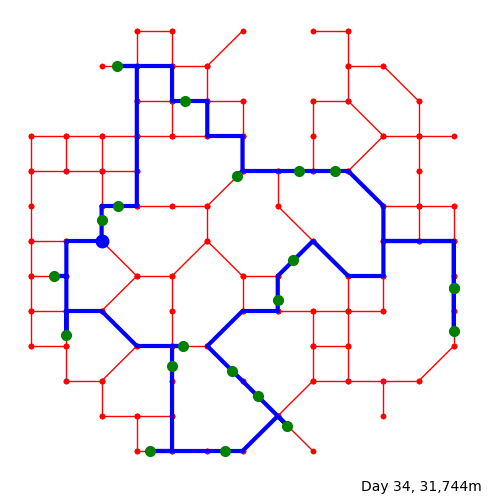

[34] 18:19:10.0 Driver leaves for delivery of 23 parcels
[34] 18:19:10.0 Driver drives to Customer: 13 (1008, 3440)
[34] 18:24:24.8 Driver arrived at Customer: 13 (1008, 3440)
[34] 18:25:39.3 Customer: 13 (1008, 3440) answers door
[34] 18:25:39.3 Customer: 13 (1008, 3440) accepts Parcel: 760 ( 13)
[34] 18:25:51.1 Customer: 13 (1008, 3440) signs off
[34] 18:26:06.8 Driver drives to Customer: 15 (1200, 2503)
[34] 18:30:37.8 Driver arrived at Customer: 15 (1200, 2503)
[34] 18:31:46.2 Customer: 15 (1200, 2503) answers door
[34] 18:31:46.2 Customer: 15 (1200, 2503) accepts Parcel: 761 ( 15)
[34] 18:31:49.3 Customer: 15 (1200, 2503) accepts Parcel: 762 ( 15)
[34] 18:31:52.7 Customer: 15 (1200, 2503) signs off
[34] 18:31:57.8 Driver drives to Customer: 57 (3051, 2320)
[34] 18:41:48.0 Driver arrived at Customer: 57 (3051, 2320)
[34] 18:41:49.0 Customer: 57 (3051, 2320) answers door
[34] 18:41:49.0 Customer: 57 (3051, 2320) accepts Parcel: 769 ( 57)
[34] 18:42:12.5 Customer: 57 (3051, 2320) sig

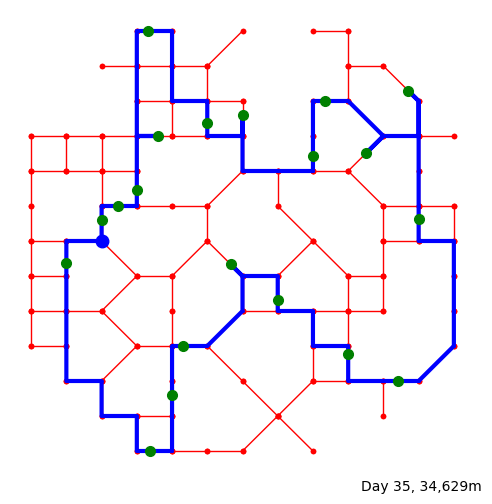

[35] 18:18:20.0 Driver leaves for delivery of 22 parcels
[35] 18:18:20.0 Driver drives to Customer: 20 (1760, 4337)
[35] 18:19:40.8 Driver arrived at Customer: 20 (1760, 4337)
[35] 18:20:58.0 Customer: 20 (1760, 4337) answers door
[35] 18:20:58.0 Customer: 20 (1760, 4337) accepts Parcel: 784 ( 20)
[35] 18:21:02.1 Customer: 20 (1760, 4337) signs off
[35] 18:21:33.0 Driver drives to Customer: 28 (2017, 4560)
[35] 18:23:28.2 Driver arrived at Customer: 28 (2017, 4560)
[35] 18:24:01.3 Customer: 28 (2017, 4560) answers door
[35] 18:24:01.3 Customer: 28 (2017, 4560) accepts Parcel: 785 ( 28)
[35] 18:24:04.8 Customer: 28 (2017, 4560) signs off
[35] 18:24:06.6 Driver drives to Customer: 34 (2320, 4813)
[35] 18:26:20.0 Driver arrived at Customer: 34 (2320, 4813)
[35] 18:27:11.8 Customer: 34 (2320, 4813) answers door
[35] 18:27:11.8 Customer: 34 (2320, 4813) accepts Parcel: 786 ( 34)
[35] 18:27:15.1 Customer: 34 (2320, 4813) signs off
[35] 18:27:31.7 Driver drives to Customer: 48 (2664, 5680)
[3

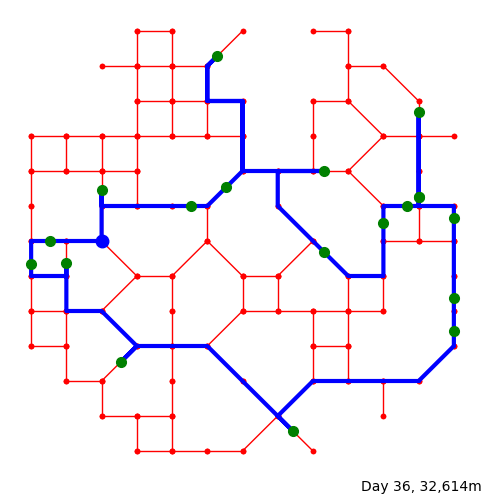

[36] 18:17:30.0 Driver leaves for delivery of 21 parcels
[36] 18:17:30.0 Driver drives to Customer: 21 (1760, 4812)
[36] 18:20:44.8 Driver arrived at Customer: 21 (1760, 4812)
[36] 18:22:56.7 Customer: 21 (1760, 4812) answers door
[36] 18:22:56.7 Customer: 21 (1760, 4812) accepts Parcel: 810 ( 21)
[36] 18:23:14.2 Customer: 21 (1760, 4812) signs off
[36] 18:23:18.4 Driver drives to Customer: 60 (3188, 4560)
[36] 18:30:01.6 Driver arrived at Customer: 60 (3188, 4560)
[36] 18:30:05.9 Customer: 60 (3188, 4560) answers door
[36] 18:30:05.9 Customer: 60 (3188, 4560) accepts Parcel: 812 ( 60)
[36] 18:30:14.2 Customer: 60 (3188, 4560) signs off
[36] 18:30:18.5 Driver drives to Customer: 73 (3738, 4858)
[36] 18:33:00.0 Driver arrived at Customer: 73 (3738, 4858)
[36] 18:33:51.4 Customer: 73 (3738, 4858) answers door
[36] 18:33:51.4 Customer: 73 (3738, 4858) accepts Parcel: 814 ( 73)
[36] 18:34:09.6 Customer: 73 (3738, 4858) signs off
[36] 18:34:18.7 Driver drives to Customer: 68 (3602, 6962)
[3

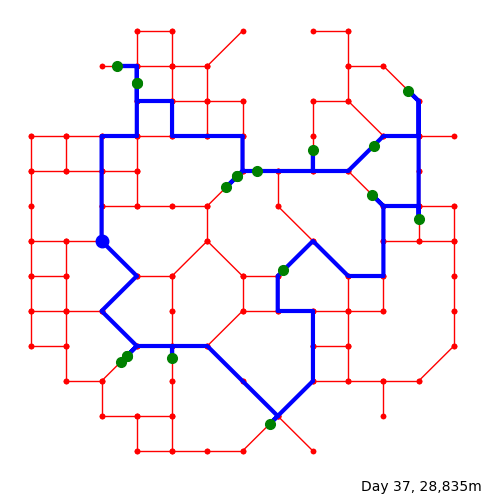

[37] 18:13:20.0 Driver leaves for delivery of 16 parcels
[37] 18:13:20.0 Driver drives to Customer: 37 (2320, 6528)
[37] 18:25:41.1 Driver arrived at Customer: 37 (2320, 6528)
[37] 18:26:47.0 Customer: 37 (2320, 6528) answers door
[37] 18:26:47.0 Customer: 37 (2320, 6528) accepts Parcel: 829 ( 37)
[37] 18:27:01.1 Customer: 37 (2320, 6528) signs off
[37] 18:27:37.9 Driver drives to Customer: 27 (2004, 6800)
[37] 18:29:59.0 Driver arrived at Customer: 27 (2004, 6800)
[37] 18:31:17.0 Customer: 27 (2004, 6800) answers door
[37] 18:31:17.0 Customer: 27 (2004, 6800) accepts Parcel: 826 ( 27)
[37] 18:31:23.9 Customer: 27 (2004, 6800) signs off
[37] 18:31:39.6 Driver drives to Customer: 78 (3913, 5033)
[37] 18:46:51.3 Driver arrived at Customer: 78 (3913, 5033)
[37] 18:47:52.9 Customer: 78 (3913, 5033) answers door
[37] 18:47:52.9 Customer: 78 (3913, 5033) accepts Parcel: 832 ( 78)
[37] 18:47:58.2 Customer: 78 (3913, 5033) signs off
[37] 18:48:03.1 Driver drives to Customer: 73 (3738, 4858)
[3

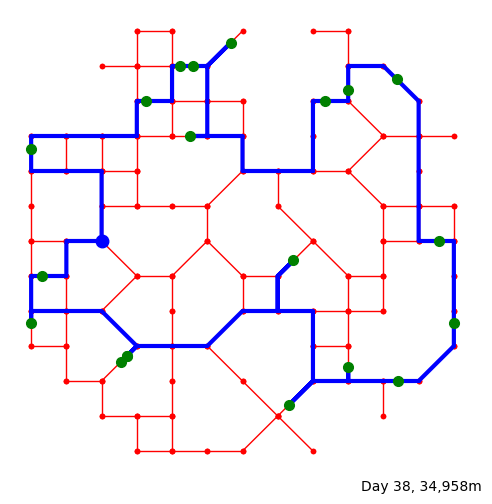

[38] 18:15:50.0 Driver leaves for delivery of 19 parcels
[38] 18:15:50.0 Driver drives to Customer:  8 (814, 3440)
[38] 18:21:51.4 Driver arrived at Customer:  8 (814, 3440)
[38] 18:22:09.9 Customer:  8 (814, 3440) answers door
[38] 18:22:09.9 Customer:  8 (814, 3440) accepts Parcel: 844 (  8)
[38] 18:22:13.4 Customer:  8 (814, 3440) signs off
[38] 18:23:07.8 Driver drives to Customer:  0 (640, 2695)
[38] 18:26:48.4 Driver arrived at Customer:  0 (640, 2695)
[38] 18:27:36.1 Customer:  0 (640, 2695) answers door
[38] 18:27:36.1 Customer:  0 (640, 2695) accepts Parcel: 842 (  0)
[38] 18:27:40.6 Customer:  0 (640, 2695) signs off
[38] 18:27:42.8 Driver drives to Customer: 32 (2164, 2164)
[38] 18:36:58.6 Driver arrived at Customer: 32 (2164, 2164)
[38] 18:37:15.2 Customer: 32 (2164, 2164) answers door
[38] 18:37:15.2 Customer: 32 (2164, 2164) accepts Parcel: 846 ( 32)
[38] 18:37:18.0 Customer: 32 (2164, 2164) signs off
[38] 18:37:35.8 Driver drives to Customer: 29 (2069, 2069)
[38] 18:38:0

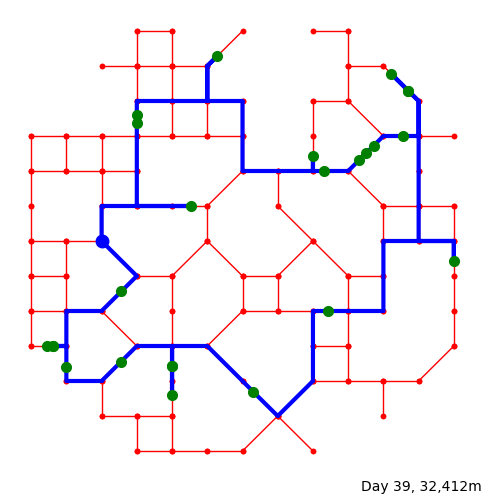

[39] 18:20:00.0 Driver leaves for delivery of 24 parcels
[39] 18:20:00.0 Driver drives to Customer: 60 (3188, 4560)
[39] 18:27:57.1 Driver arrived at Customer: 60 (3188, 4560)
[39] 18:28:12.0 Customer: 60 (3188, 4560) answers door
[39] 18:28:12.0 Customer: 60 (3188, 4560) accepts Parcel: 872 ( 60)
[39] 18:28:13.5 Customer: 60 (3188, 4560) signs off
[39] 18:28:14.0 Driver drives to Customer: 35 (2320, 5885)
[39] 18:37:00.3 Driver arrived at Customer: 35 (2320, 5885)
[39] 18:37:47.2 Customer: 35 (2320, 5885) answers door
[39] 18:37:47.2 Customer: 35 (2320, 5885) accepts Parcel: 866 ( 35)
[39] 18:37:47.8 Customer: 35 (2320, 5885) accepts Parcel: 867 ( 35)
[39] 18:37:56.8 Customer: 35 (2320, 5885) signs off
[39] 18:37:57.5 Driver drives to Customer: 36 (2320, 6014)
[39] 18:38:28.5 Driver arrived at Customer: 36 (2320, 6014)
[39] 18:38:33.3 Customer: 36 (2320, 6014) answers door
[39] 18:38:33.3 Customer: 36 (2320, 6014) accepts Parcel: 868 ( 36)
[39] 18:38:38.3 Customer: 36 (2320, 6014) acc

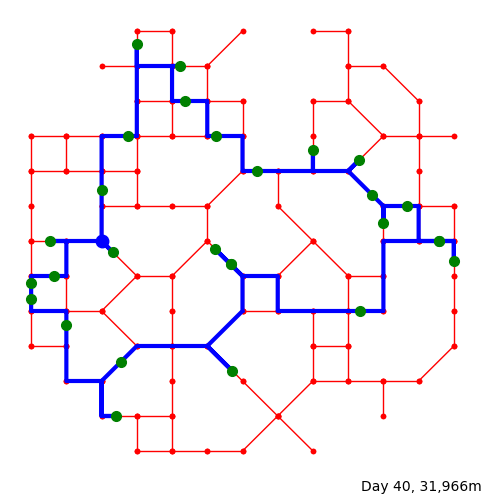

[40] 18:23:20.0 Driver leaves for delivery of 28 parcels
[40] 18:23:20.0 Driver drives to Customer: 10 (932, 4000)
[40] 18:26:38.7 Driver arrived at Customer: 10 (932, 4000)
[40] 18:29:36.2 Customer: 10 (932, 4000) answers door
[40] 18:29:36.2 Customer: 10 (932, 4000) accepts Parcel: 888 ( 10)
[40] 18:29:40.3 Customer: 10 (932, 4000) signs off
[40] 18:29:46.2 Driver drives to Customer: 13 (1008, 3440)
[40] 18:33:51.0 Driver arrived at Customer: 13 (1008, 3440)
[40] 18:34:07.8 Customer: 13 (1008, 3440) answers door
[40] 18:34:07.8 Customer: 13 (1008, 3440) accepts Parcel: 889 ( 13)
[40] 18:34:11.7 Customer: 13 (1008, 3440) signs off
[40] 18:34:14.4 Driver drives to Customer:  2 (640, 3330)
[40] 18:36:09.2 Driver arrived at Customer:  2 (640, 3330)
[40] 18:36:26.6 Customer:  2 (640, 3330) answers door
[40] 18:36:26.6 Customer:  2 (640, 3330) accepts Parcel: 887 (  2)
[40] 18:36:31.1 Customer:  2 (640, 3330) signs off
[40] 18:36:35.5 Driver drives to Customer:  1 (640, 3080)
[40] 18:37:35

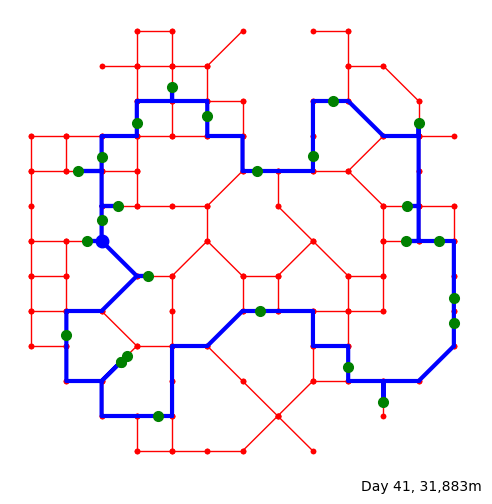

[41] 18:20:50.0 Driver leaves for delivery of 25 parcels
[41] 18:20:50.0 Driver drives to Customer: 19 (1522, 4000)
[41] 18:21:47.1 Driver arrived at Customer: 19 (1522, 4000)
[41] 18:22:19.4 Customer: 19 (1522, 4000) answers door
[41] 18:22:19.4 Customer: 19 (1522, 4000) accepts Parcel: 915 ( 19)
[41] 18:22:30.5 Customer: 19 (1522, 4000) signs off
[41] 18:22:39.6 Driver drives to Customer: 20 (1760, 4337)
[41] 18:24:57.6 Driver arrived at Customer: 20 (1760, 4337)
[41] 18:25:54.2 Customer: 20 (1760, 4337) answers door
[41] 18:25:54.2 Customer: 20 (1760, 4337) accepts Parcel: 916 ( 20)
[41] 18:26:00.4 Customer: 20 (1760, 4337) signs off
[41] 18:26:08.7 Driver drives to Customer: 28 (2017, 4560)
[41] 18:28:03.9 Driver arrived at Customer: 28 (2017, 4560)
[41] 18:29:47.9 Customer: 28 (2017, 4560) answers door
[41] 18:29:47.9 Customer: 28 (2017, 4560) accepts Parcel: 918 ( 28)
[41] 18:29:50.9 Customer: 28 (2017, 4560) signs off
[41] 18:30:01.8 Driver drives to Customer: 18 (1390, 5120)
[4

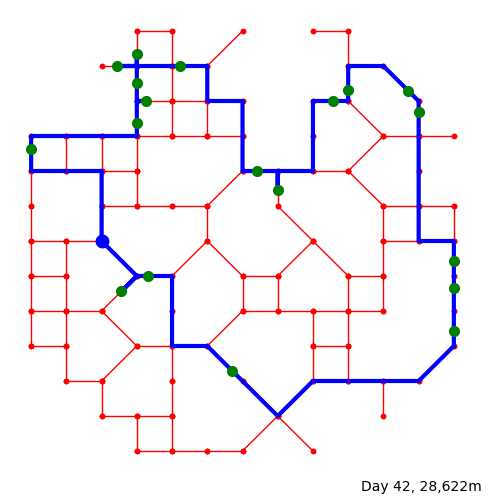

[42] 18:15:50.0 Driver leaves for delivery of 19 parcels
[42] 18:15:50.0 Driver drives to Customer:  7 (640, 5473)
[42] 18:26:12.3 Driver arrived at Customer:  7 (640, 5473)
[42] 18:26:19.9 Customer:  7 (640, 5473) answers door
[42] 18:26:19.9 Customer:  7 (640, 5473) accepts Parcel: 938 (  7)
[42] 18:26:23.3 Customer:  7 (640, 5473) signs off
[42] 18:26:29.7 Driver drives to Customer: 35 (2320, 5885)
[42] 18:34:51.8 Driver arrived at Customer: 35 (2320, 5885)
[42] 18:35:22.9 Customer: 35 (2320, 5885) answers door
[42] 18:35:22.9 Customer: 35 (2320, 5885) accepts Parcel: 941 ( 35)
[42] 18:35:26.5 Customer: 35 (2320, 5885) signs off
[42] 18:35:52.4 Driver drives to Customer: 40 (2462, 6240)
[42] 18:37:51.7 Driver arrived at Customer: 40 (2462, 6240)
[42] 18:38:48.4 Customer: 40 (2462, 6240) answers door
[42] 18:38:48.4 Customer: 40 (2462, 6240) accepts Parcel: 944 ( 40)
[42] 18:38:58.3 Customer: 40 (2462, 6240) signs off
[42] 18:38:59.0 Driver drives to Customer: 37 (2320, 6528)
[42] 18

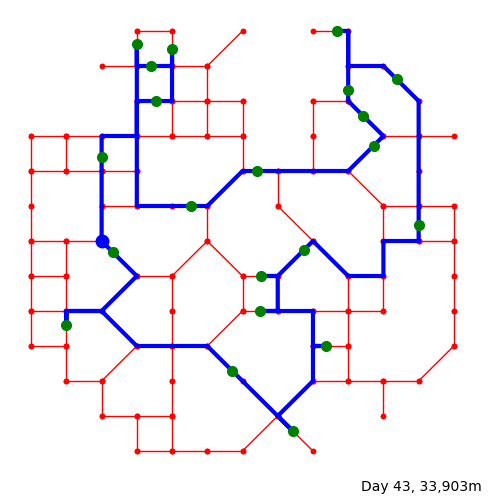

[43] 18:19:10.0 Driver leaves for delivery of 23 parcels
[43] 18:19:10.0 Driver drives to Customer: 23 (1760, 5352)
[43] 18:24:34.4 Driver arrived at Customer: 23 (1760, 5352)
[43] 18:25:07.4 Customer: 23 (1760, 5352) answers door
[43] 18:25:07.4 Customer: 23 (1760, 5352) accepts Parcel: 958 ( 23)
[43] 18:25:07.7 Customer: 23 (1760, 5352) signs off
[43] 18:25:20.9 Driver drives to Customer: 46 (2629, 6240)
[43] 18:32:22.6 Driver arrived at Customer: 46 (2629, 6240)
[43] 18:34:46.3 Customer: 46 (2629, 6240) answers door
[43] 18:34:46.3 Customer: 46 (2629, 6240) accepts Parcel: 962 ( 46)
[43] 18:34:47.9 Customer: 46 (2629, 6240) signs off
[43] 18:35:00.4 Driver drives to Customer: 55 (2880, 7072)
[43] 18:39:20.4 Driver arrived at Customer: 55 (2880, 7072)
[43] 18:39:54.3 Customer: 55 (2880, 7072) answers door
[43] 18:39:54.3 Customer: 55 (2880, 7072) accepts Parcel: 963 ( 55)
[43] 18:40:02.1 Customer: 55 (2880, 7072) signs off
[43] 18:40:07.8 Driver drives to Customer: 45 (2541, 6800)
[4

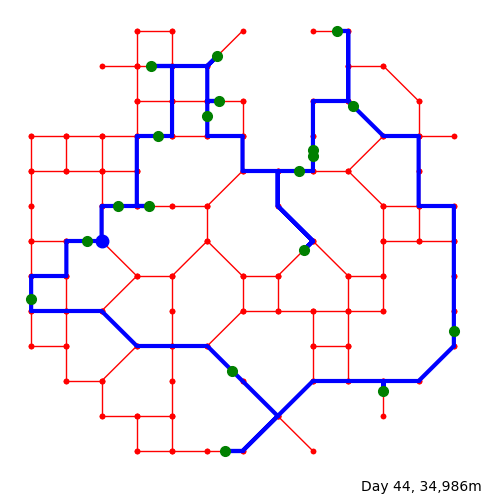

[44] 18:16:40.0 Driver leaves for delivery of 20 parcels
[44] 18:16:40.0 Driver drives to Customer: 28 (2017, 4560)
[44] 18:19:56.0 Driver arrived at Customer: 28 (2017, 4560)
[44] 18:20:00.1 Customer: 28 (2017, 4560) answers door
[44] 18:20:00.1 Customer: 28 (2017, 4560) accepts Parcel: 983 ( 28)
[44] 18:20:01.8 Customer: 28 (2017, 4560) signs off
[44] 18:20:21.1 Driver drives to Customer: 43 (2519, 4560)
[44] 18:22:21.6 Driver arrived at Customer: 43 (2519, 4560)
[44] 18:22:29.5 Customer: 43 (2519, 4560) answers door
[44] 18:22:29.5 Customer: 43 (2519, 4560) accepts Parcel: 984 ( 43)
[44] 18:22:35.4 Customer: 43 (2519, 4560) signs off
[44] 18:22:36.3 Driver drives to Customer: 48 (2664, 5680)
[44] 18:29:15.4 Driver arrived at Customer: 48 (2664, 5680)
[44] 18:30:19.1 Customer: 48 (2664, 5680) answers door
[44] 18:30:19.1 Customer: 48 (2664, 5680) accepts Parcel: 986 ( 48)
[44] 18:30:22.2 Customer: 48 (2664, 5680) signs off
[44] 18:30:33.1 Driver drives to Customer: 45 (2541, 6800)
[4

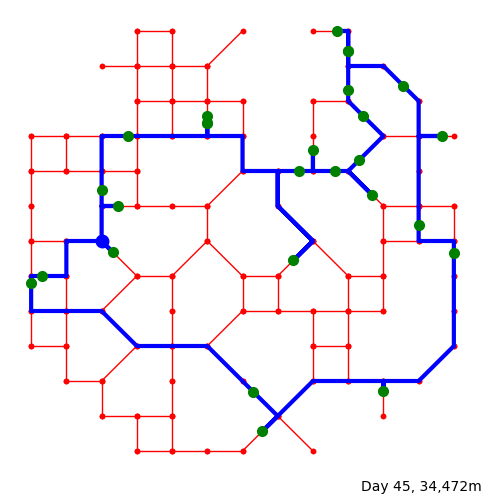

[45] 18:23:20.0 Driver leaves for delivery of 28 parcels
[45] 18:23:20.0 Driver drives to Customer: 24 (1935, 3824)
[45] 18:24:19.5 Driver arrived at Customer: 24 (1935, 3824)
[45] 18:24:38.2 Customer: 24 (1935, 3824) answers door
[45] 18:24:38.2 Customer: 24 (1935, 3824) accepts Parcel: 1006 ( 24)
[45] 18:24:58.1 Customer: 24 (1935, 3824) signs off
[45] 18:25:07.8 Driver drives to Customer: 28 (2017, 4560)
[45] 18:29:23.4 Driver arrived at Customer: 28 (2017, 4560)
[45] 18:31:31.5 Customer: 28 (2017, 4560) answers door
[45] 18:31:31.5 Customer: 28 (2017, 4560) accepts Parcel: 1007 ( 28)
[45] 18:31:34.0 Customer: 28 (2017, 4560) signs off
[45] 18:31:34.1 Driver drives to Customer: 21 (1760, 4812)
[45] 18:33:36.3 Driver arrived at Customer: 21 (1760, 4812)
[45] 18:34:52.7 Customer: 21 (1760, 4812) answers door
[45] 18:34:52.7 Customer: 21 (1760, 4812) accepts Parcel: 1005 ( 21)
[45] 18:35:02.1 Customer: 21 (1760, 4812) signs off
[45] 18:35:03.5 Driver drives to Customer: 33 (2180, 5680)

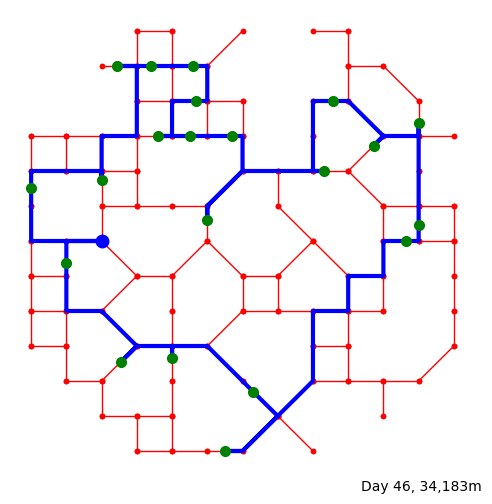

[46] 18:20:00.0 Driver leaves for delivery of 24 parcels
[46] 18:20:00.0 Driver drives to Customer: 17 (1200, 3643)
[46] 18:23:40.0 Driver arrived at Customer: 17 (1200, 3643)
[46] 18:24:44.7 Customer: 17 (1200, 3643) answers door
[46] 18:24:44.7 Customer: 17 (1200, 3643) accepts Parcel: 1029 ( 17)
[46] 18:24:45.9 Customer: 17 (1200, 3643) accepts Parcel: 1030 ( 17)
[46] 18:24:51.4 Customer: 17 (1200, 3643) signs off
[46] 18:25:02.4 Driver drives to Customer: 29 (2069, 2069)
[46] 18:34:54.7 Driver arrived at Customer: 29 (2069, 2069)
[46] 18:35:30.7 Customer: 29 (2069, 2069) answers door
[46] 18:35:30.7 Customer: 29 (2069, 2069) accepts Parcel: 1033 ( 29)
[46] 18:35:51.3 Customer: 29 (2069, 2069) signs off
[46] 18:36:11.7 Driver drives to Customer: 51 (2880, 2123)
[46] 18:40:38.3 Driver arrived at Customer: 51 (2880, 2123)
[46] 18:41:09.9 Customer: 51 (2880, 2123) answers door
[46] 18:41:09.9 Customer: 51 (2880, 2123) accepts Parcel: 1036 ( 51)
[46] 18:41:31.8 Customer: 51 (2880, 2123)

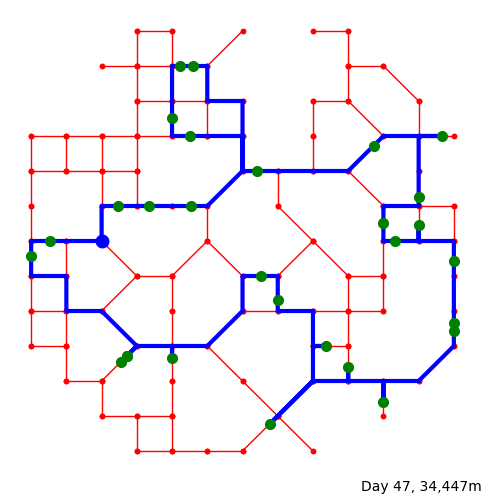

[47] 18:26:40.0 Driver leaves for delivery of 32 parcels
[47] 18:26:40.0 Driver drives to Customer: 28 (2017, 4560)
[47] 18:29:56.0 Driver arrived at Customer: 28 (2017, 4560)
[47] 18:30:00.3 Customer: 28 (2017, 4560) answers door
[47] 18:30:00.3 Customer: 28 (2017, 4560) accepts Parcel: 1057 ( 28)
[47] 18:30:00.7 Customer: 28 (2017, 4560) signs off
[47] 18:30:04.7 Driver drives to Customer: 43 (2519, 4560)
[47] 18:32:05.1 Driver arrived at Customer: 43 (2519, 4560)
[47] 18:32:10.0 Customer: 43 (2519, 4560) answers door
[47] 18:32:10.0 Customer: 43 (2519, 4560) accepts Parcel: 1061 ( 43)
[47] 18:32:13.3 Customer: 43 (2519, 4560) signs off
[47] 18:33:02.7 Driver drives to Customer: 60 (3188, 4560)
[47] 18:35:43.2 Driver arrived at Customer: 60 (3188, 4560)
[47] 18:35:54.2 Customer: 60 (3188, 4560) answers door
[47] 18:35:54.2 Customer: 60 (3188, 4560) accepts Parcel: 1066 ( 60)
[47] 18:36:09.7 Customer: 60 (3188, 4560) signs off
[47] 18:36:25.3 Driver drives to Customer: 59 (3173, 5680)

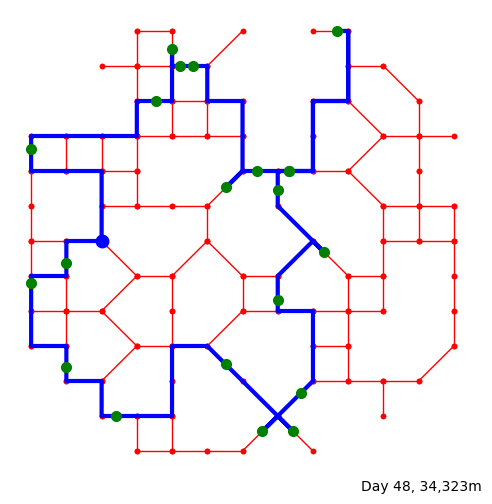

[48] 18:20:50.0 Driver leaves for delivery of 25 parcels
[48] 18:20:50.0 Driver drives to Customer: 17 (1200, 3643)
[48] 18:24:30.0 Driver arrived at Customer: 17 (1200, 3643)
[48] 18:24:41.0 Customer: 17 (1200, 3643) answers door
[48] 18:24:41.0 Customer: 17 (1200, 3643) accepts Parcel: 1087 ( 17)
[48] 18:24:47.6 Customer: 17 (1200, 3643) accepts Parcel: 1088 ( 17)
[48] 18:24:56.8 Customer: 17 (1200, 3643) signs off
[48] 18:24:59.9 Driver drives to Customer:  2 (640, 3330)
[48] 18:28:29.4 Driver arrived at Customer:  2 (640, 3330)
[48] 18:28:38.5 Customer:  2 (640, 3330) answers door
[48] 18:28:38.5 Customer:  2 (640, 3330) accepts Parcel: 1084 (  2)
[48] 18:28:45.9 Customer:  2 (640, 3330) signs off
[48] 18:28:52.6 Driver drives to Customer: 14 (1200, 1985)
[48] 18:36:29.8 Driver arrived at Customer: 14 (1200, 1985)
[48] 18:36:32.9 Customer: 14 (1200, 1985) answers door
[48] 18:36:32.9 Customer: 14 (1200, 1985) accepts Parcel: 1086 ( 14)
[48] 18:36:35.5 Customer: 14 (1200, 1985) sign

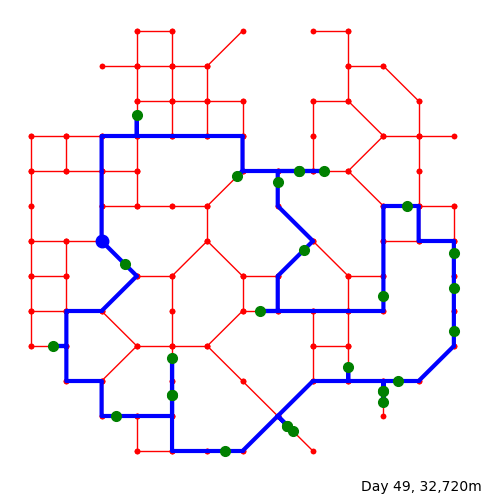

[49] 18:22:30.0 Driver leaves for delivery of 27 parcels
[49] 18:22:30.0 Driver drives to Customer: 36 (2320, 6014)
[49] 18:32:47.7 Driver arrived at Customer: 36 (2320, 6014)
[49] 18:33:33.2 Customer: 36 (2320, 6014) answers door
[49] 18:33:33.2 Customer: 36 (2320, 6014) accepts Parcel: 1116 ( 36)
[49] 18:34:15.2 Customer: 36 (2320, 6014) signs off
[49] 18:34:25.4 Driver drives to Customer: 78 (3913, 5033)
[49] 18:45:12.6 Driver arrived at Customer: 78 (3913, 5033)
[49] 18:46:18.7 Customer: 78 (3913, 5033) answers door
[49] 18:46:18.7 Customer: 78 (3913, 5033) accepts Parcel: 1120 ( 78)
[49] 18:46:35.4 Customer: 78 (3913, 5033) signs off
[49] 18:46:38.4 Driver drives to Customer: 96 (4899, 5120)
[49] 18:50:43.7 Driver arrived at Customer: 96 (4899, 5120)
[49] 18:51:03.5 Customer: 96 (4899, 5120) answers door
[49] 18:51:03.5 Customer: 96 (4899, 5120) accepts Parcel: 1125 ( 96)
[49] 18:51:05.7 Customer: 96 (4899, 5120) signs off
[49] 18:51:15.0 Driver drives to Customer: 102 (5297, 5120

In [ ]:
random.seed(7635)
W = generateWarehouseLocation(M)
rec = simulation(M, W, C, p=0.15, days=50, plot=True, log=True, timing=True)
with open('rec.pickle', 'wb') as f:
            pickle.dump(rec, f)

In [ ]:
rec.reportTimer()

==== t: 1232.12s Total
==== ΣΔt: 1093.92s createLoop
==== ΣΔt: 131.02s createLoopH
==== ΣΔt:   7.06s addTarget


In [ ]:
with open('rec.pickle', 'rb') as f:
    sim = pickle.load(f)

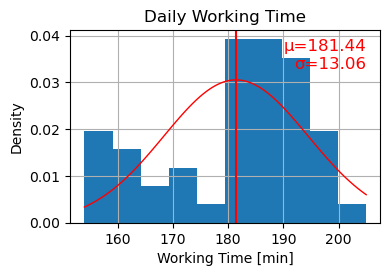

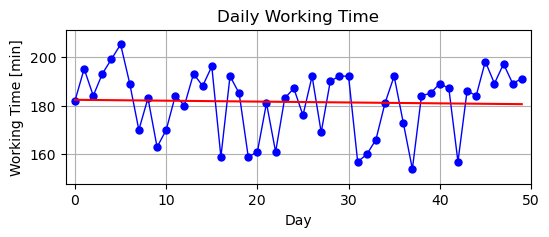

(181.44, 184.5, 13.189606297600935)

In [ ]:
rec.histWorkingTime()
rec.plotWorkingTime()
rec.statsWorkingTime()

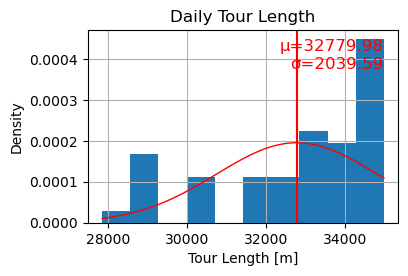

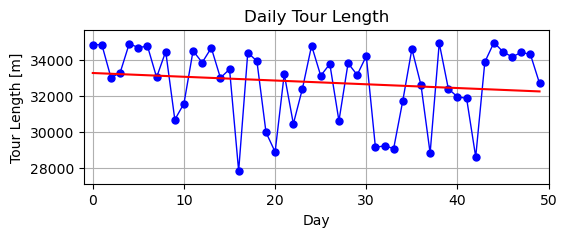

(32779.98, 33270.5, 2060.296932136586)

In [ ]:
rec.histTourLength()
rec.plotTourLength()
rec.statsTourLength()

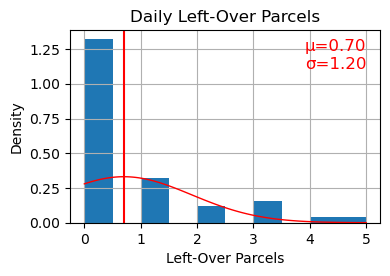

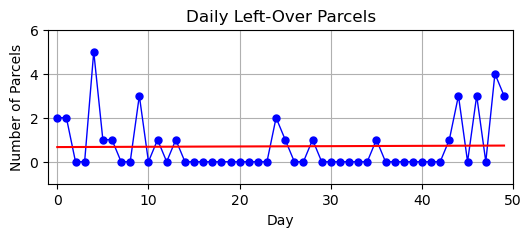

(0.7, 0.0, 1.2163847404233143)

In [ ]:
rec.histLeftOver()
rec.plotLeftOver()
rec.statsLeftOver()

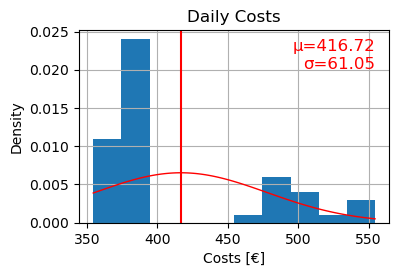

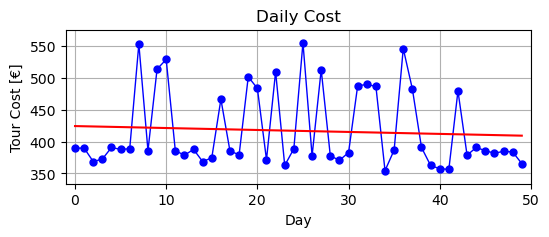

(416.71600000000007, 386.22, 61.67063390070095)

In [ ]:
rec.histCosts()
rec.plotCosts()
rec.statsCosts()

## Optimisation

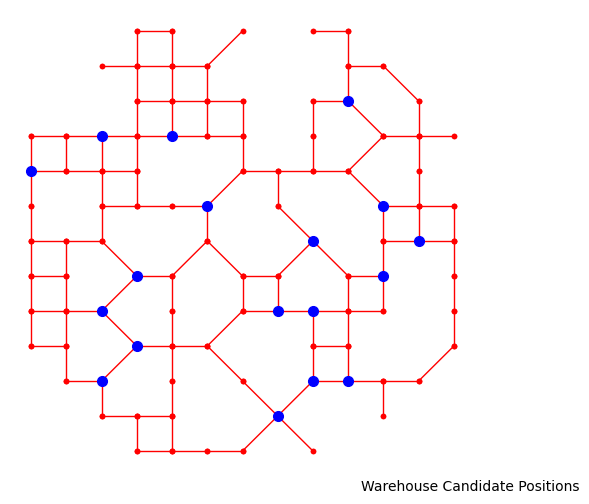

Simulate Delivery from Warehouse (2320, 2320)
 Improved position: (2320, 2320) f=31999.33
Simulate Delivery from Warehouse (4560, 2880)
 Improved position: (4560, 2880) f=31804.00
Simulate Delivery from Warehouse (5120, 4000)
Simulate Delivery from Warehouse (1760, 1760)
Simulate Delivery from Warehouse (3440, 4560)
Simulate Delivery from Warehouse ( 640, 5120)
Simulate Delivery from Warehouse (6240, 3440)
Simulate Delivery from Warehouse (5680, 1760)
Simulate Delivery from Warehouse (1760, 5680)
 Improved position: (1760, 5680) f=31626.00
Simulate Delivery from Warehouse (2880, 5680)
Simulate Delivery from Warehouse (5680, 6240)
Simulate Delivery from Warehouse (4560, 1200)
Simulate Delivery from Warehouse (1760, 2880)
Simulate Delivery from Warehouse (2320, 3440)
Simulate Delivery from Warehouse (5120, 1760)
Simulate Delivery from Warehouse (6240, 4560)
Simulate Delivery from Warehouse (6800, 4000)
Simulate Delivery from Warehouse (5120, 2880)


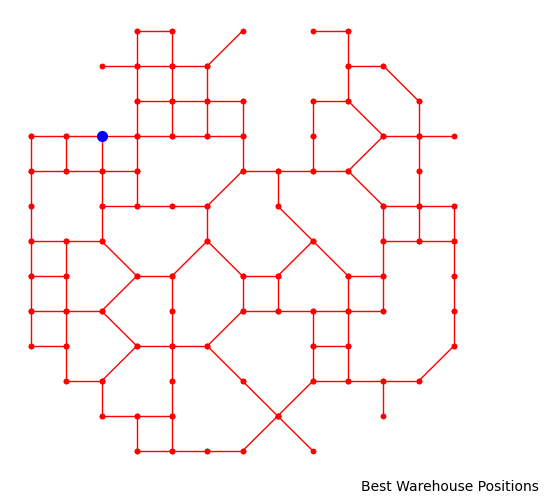

In [ ]:
import pickle

with open('data.pickled', 'rb') as f:
    M, C= pickle.load(f)

def generateWarehouseLocations(M, p):

    def numberOfEdges(v, E):
        count=0
        for e in E:
            if e[0]==v or e[1]==v:
                count +=1
        return count

    V, E= M
    W = [v for v in V if numberOfEdges(v, E)>2]
    return random.sample(W, k= int(round(len(W)*p)))

def formatLocation(w):
    return f"({w[0]:4d}, {w[1]:4d})"

def objectiveFunction(w, seed=0):
    random.seed(seed)
    title = "Simulate Delivery from Warehouse "+formatLocation(w)
    rec = simulation(M, w, C, p=0.16, days=3, title=title)
    filename = "_/rec w="+formatLocation(w)+".pickled"
    with open(filename, 'wb') as f:
        pickle.dump(rec, f)
    return rec.statsTourLength()[0] # mean tour length

def MonteCarlo(M, p):

    W = generateWarehouseLocations(M,p)
    plotMap(M, T=W, styleT='bo', msT=7,
            text= "Warehouse Candidate Positions")

    minW, minP = None, math.inf
    for w in W:
        f= objectiveFunction(w)
        if f < minP:
            print(f" Improved position: {formatLocation(w):s} f={f:7.2f}")
            minW, minP = [w], f
        elif f == minP:
            print(f" Equivalent position: {formatLocation(w):s} f={f:7.2f}")
            minW.append(w)

    return minW

random.seed(7635)
W = MonteCarlo(M, 0.28)
plotMap(M, T=W, styleT='bo', msT=7, text='Best Warehouse Positions')

# 11. Results and Interpretation

In [ ]:
type(rec.daily)

pandas.core.frame.DataFrame

In [ ]:
df_sim = rec.daily
df_sim

,begin work at,end work at,dist,left,cost,working time
0,64800,75761,34872,2,389.72,182
1,151200,162933,34862,2,389.72,195
2,237600,248659,33025,0,368.64,184
3,324000,335602,33309,0,372.64,193
4,410400,422385,34924,5,390.72,199
5,496800,509124,34703,1,387.72,205
6,583200,594568,34791,1,388.72,189
7,669600,679835,33052,0,552.64,170
8,756000,767016,34488,0,385.72,183
9,842400,852198,30698,3,513.4,163


In [ ]:
df_sim= df_sim.astype(float)

In [ ]:
df_sim.rename(columns = {'working time': 'working_time'}, inplace = True)

In [ ]:
df_sim.describe()

,begin work at,end work at,dist,left,cost,working_time
count,5.000000e+01,5.000000e+01,50.000000,50.000000,50.000000,50.000000
mean,2.181600e+06,2.192516e+06,32779.980000,0.700000,416.716000,181.440000
std,1.259486e+06,1.259454e+06,2060.296932,1.216385,61.670634,13.189606
min,6.480000e+04,7.576100e+04,27847.000000,0.000000,354.480000,154.000000
25%,1.123200e+06,1.134222e+06,31778.750000,0.000000,377.640000,170.750000
50%,2.181600e+06,2.192534e+06,33270.500000,0.000000,386.220000,184.500000
75%,3.240000e+06,3.249564e+06,34465.750000,1.000000,481.490000,191.750000
max,4.298400e+06,4.309909e+06,34986.000000,5.000000,554.640000,205.000000


In [ ]:
def cost_check(df_sim):
    df_sim['Cost_Group']=0
    for index,row in df_sim.iterrows():
        status=None
        i=row['cost']
        try:
            if (0<i<=370):
                status='Group1'
            elif (370<i<=390):
                status='Group2'
            elif (390<i<=480):
                status='Group3'
            else:
                status='Group4'
        except ValueError as err:
            pass
        df_sim['Cost_Group'].iloc[index]=status
    return df_sim

In [ ]:
df_sim = cost_check(df_sim)

C:\Users\reyna\AppData\Local\Temp\ipykernel_34844\3124764089.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\reyna\AppData\Local\Temp\ipykernel_34844\3124764089.py:17: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Group2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



In [ ]:
df_sim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   begin work at  50 non-null     float64
 1   end work at    50 non-null     float64
 2   dist           50 non-null     float64
 3   left           50 non-null     float64
 4   cost           50 non-null     float64
 5   working_time   50 non-null     float64
 6   Cost_Group     50 non-null     object 
dtypes: float64(6), object(1)
memory usage: 2.9+ KB


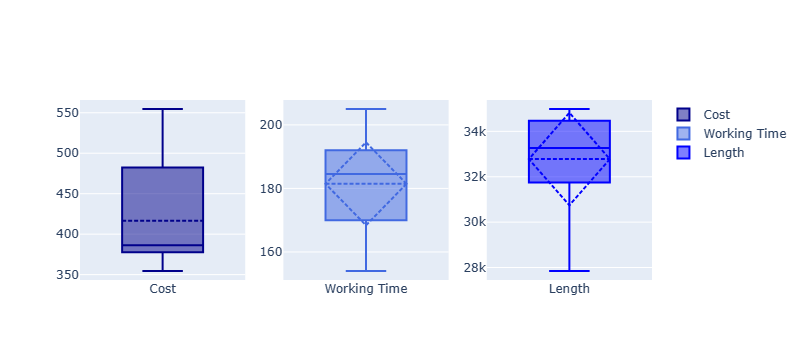

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(1,3)

fig.add_trace(go.Box(
    y=df_sim['cost'],
    name='Cost',
    marker_color='darkblue',
    boxmean=True # represent mean
),1,1)
fig.add_trace(go.Box(
    y=df_sim['working_time'],
    name='Working Time',
    marker_color='royalblue',
    boxmean='sd' # represent mean and standard deviation
),1,2)
fig.add_trace(go.Box(
    y=df_sim['dist'],
    name='Length',
    marker_color='blue',
    boxmean='sd' # represent mean and standard deviation
),1,3)

fig.show()

In [ ]:
# reshape the d dataframe suitable for statsmodels package
df_analysis= pd.DataFrame({'Group1':df_sim[df_sim['Cost_Group']=='Group1']['cost'],
                           'Group2':df_sim[df_sim['Cost_Group']=='Group2']['cost'],
                           'Group3':df_sim[df_sim['Cost_Group']=='Group3']['cost'],
                           'Group4':df_sim[df_sim['Cost_Group']=='Group4']['cost']})


In [ ]:
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Group1  8 non-null      float64
 1   Group2  24 non-null     float64
 2   Group3  5 non-null      float64
 3   Group4  13 non-null     float64
dtypes: float64(4)
memory usage: 2.0 KB


In [ ]:
np.random.seed(1234)
df_sample=pd.DataFrame({'Group1':random.sample(list(df_sim['cost'][df_sim['Cost_Group']=='Group1']), 5),
                        'Group2':random.sample(list(df_sim['cost'][df_sim['Cost_Group']=='Group2']), 5),
                        'Group3':random.sample(list(df_sim['cost'][df_sim['Cost_Group']=='Group3']), 5),
                        'Group4':random.sample(list(df_sim['cost'][df_sim['Cost_Group']=='Group4']), 5)})

In [ ]:
df_sample

,Group1,Group2,Group3,Group4
0,356.48,377.64,390.72,513.40
1,368.64,389.72,390.72,545.56
2,362.56,387.72,390.72,487.32
3,354.48,377.64,479.24,509.40
4,357.48,388.72,466.16,501.32


In [ ]:
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(df_sample['Group1'],df_sample['Group2'], df_sample['Group3'], df_sample['Group4'])
print(fvalue, pvalue)

34.34956329863586 3.334811111754e-07


In [ ]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# reshape the d dataframe suitable for statsmodels package
df_melt = pd.melt(df_sample.reset_index(), id_vars=['index'], value_vars=['Group1', 'Group2', 'Group3', 'Group4'])

# replace column names
df_melt.columns = ['index', 'simulations', 'value']

# Ordinary Least Squares (OLS) model
model = ols('value ~ simulations', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
simulations,66250.48088,3.0,34.349563,3.334811e-07
Residual,10286.47424,16.0,NaN,NaN


In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     34.35
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           3.33e-07
Time:                        01:09:12   Log-Likelihood:                -90.807
No. Observations:                  20   AIC:                             189.6
Df Residuals:                      16   BIC:                             193.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               359.9280     11.339     31.741      0.000     335.890     383.966
simulations[T.Group2]    24.3600     16.036      1.519      0.148      -9.635      58.355
simulations[T.Group3]    63.5840     16.036      3.965      0.001      29.589      97.579
simulations[T.Group4]   151.4720     16.036      9.446      0.000     117.477     185.467
==============================================================================
Omnibus:                        3.572   Durbin-Watson:                   1.621
Prob(Omnibus):                  0.168   Jarque-Bera (JB):                1.921
Skew:                           0.728   Prob(JB):                        0.383
Kurtosis:                       3.429   Cond. No.                         4.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

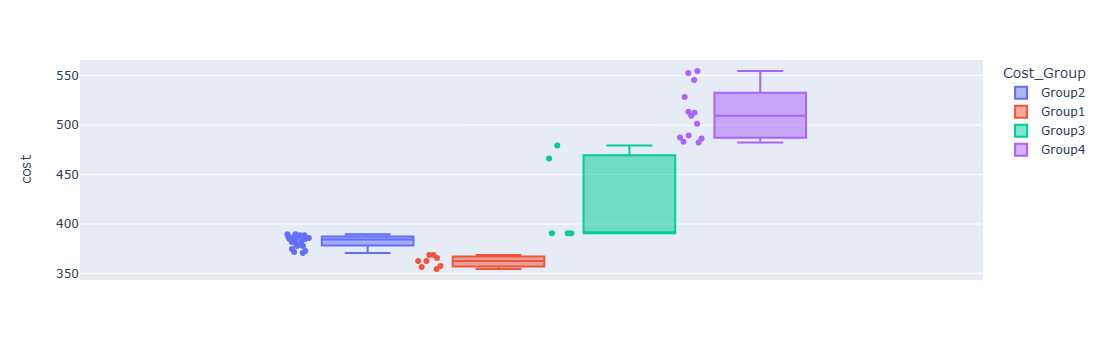

In [ ]:
import plotly.express as px

fig2 = px.box(df_sim, y="cost", points="all", color="Cost_Group")
fig2.show()

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

mc = MultiComparison(df_sim['dist'], df_sim['cost'])
tukey_result = mc.tukeyhsd(alpha=0.05)

print(tukey_result)
print('Unique Cost groups: {}'.format(mc.groupsunique))

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2 meandiff p-adj    lower      upper    reject
----------------------------------------------------------
354.48 356.48    139.0 0.0995   -15.5307   293.5307  False
354.48 357.48    222.0 0.0027    67.4693   376.5307   True
354.48 362.56    677.0    0.0   543.1724   810.8276   True
354.48 365.56    976.0    0.0   821.4693  1130.5307   True
354.48 368.64   1278.5    0.0  1144.6724  1412.3276   True
354.48 370.64   1440.0    0.0  1285.4693  1594.5307   True
354.48 371.64   1488.0    0.0  1333.4693  1642.5307   True
354.48 372.64   1565.0    0.0  1410.4693  1719.5307   True
354.48 374.64   1759.0    0.0  1604.4693  1913.5307   True
354.48 377.64   2071.0    0.0  1937.1724  2204.8276   True
354.48 378.64   2144.5    0.0  2010.6724  2278.3276   True
354.48 379.64   2216.0    0.0  2061.4693  2370.5307   True
354.48 381.72   2439.0    0.0  2284.4693  2593.5307   True
354.48 382.72   2494.0    0.0  2339.4693  2648.5307   Tr

The ANOVA F value can tell you if there is a significant difference between the levels of the independent variable, when p < .05. So, a higher F value indicates that the treatment variables are significant.